# Демонстрация процесса обучения модели на примере классификации

In [1]:
# расширяем поле, убираем предупреждения
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:95% !important;}</style>'))

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Импорт необходимых библиотек для анализа
import pandas as pd
import numpy as np
from scipy.stats import skew, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

# Импорт необходимых библиотек для схемы обучения и проверки
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GroupKFold, GroupShuffleSplit
from sklearn.metrics import roc_auc_score, f1_score

# Импорт необходимых алгоритмов для обучения
import lightgbm as lgb
import xgboost as xgb
import catboost as catb

In [3]:
# Определение пути разработанной библиотеки
import sys
sys.path.append('../')

In [4]:
# Наша разработанная библиотека
from autobinary import NansAnalysis, base_pipe, StratifiedGroupKFold, PrimarySelection
from autobinary import AutoTrees, AutoSelection
from autobinary import FinalModel, PlotShap, PlotPDP

In [5]:
import sklearn as sk
import catboost as ctb
import matplotlib as mplot
import autobinary as ab
import numpy as np
import scipy as sc

print('pandas: ', pd.__version__)
print('numpy: ', np.__version__)
print('scipy: ', sc.__version__)
print('sklearn: ', sk.__version__)
print('lightboost: ', ctb.__version__)
print('matplotlib: ', mplot.__version__)
print('autobinary: ', ab.__version__)

pandas:  1.3.5
numpy:  1.21.5
scipy:  1.7.3
sklearn:  1.0.2
lightboost:  1.1.1
matplotlib:  3.5.1
autobinary:  1.0.7


## Начало анализа

In [5]:
sample = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')

print('Размерность данных:', sample.shape)
sample.head(2)

Размерность данных: (891, 12)


PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   

   Parch     Ticket     Fare Cabin Embarked  
0      0  A/5 21171   7.2500   NaN        S  
1      0   PC 17599  71.2833   C85        C

In [6]:
num_columns = [
    'Age', 'Fare'
]

cat_columns = [
    'Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch'
]

features = num_columns + cat_columns

target = 'Survived'

In [7]:
# Обновление пайплайна трансформации

prep_pipe = base_pipe(
    num_columns=num_columns, 
    cat_columns=cat_columns
)

Определены количественные и категориальные переменные!


In [8]:
# обработка бесконечных и пропущенных значений

nans = NansAnalysis(df=sample)

sample = nans.to_types(num_columns=num_columns)
sample.head()

Все бесконечные значения заменены на пропуски, количественные переменные приведены к типу float!


PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [9]:
# Проводим анализ на пропущенные значения. Столбцы имеющие пропусков больше percent.

feat_after_nans = nans.fit(percent = 0.9)

# Обновляем факторы

num_columns = list(filter(lambda x: x in feat_after_nans, num_columns))
cat_columns = list(filter(lambda x: x in feat_after_nans, cat_columns))

Количество столбцов до: 12
Удалены столбцы, имеющие долю пропусков > 90.0 %, количество оставшихся : 12 


In [10]:
# Функция nans_df - датафрейм с пропущенными значениями

nans.nans_df

feature  cnt_null  share_nans
10        Cabin       687        0.77
5           Age       177        0.20
11     Embarked         2        0.00
0   PassengerId         0        0.00
1      Survived         0        0.00
2        Pclass         0        0.00
3          Name         0        0.00
4           Sex         0        0.00
6         SibSp         0        0.00
7         Parch         0        0.00
8        Ticket         0        0.00
9          Fare         0        0.00

In [11]:
# Разделим генеральную совокупность на обучающее и тестовое множества.

X_train, X_valid, y_train, y_valid = train_test_split(
    sample,
    sample[target],
    test_size=0.3,
    stratify=sample[target],
    random_state=42
)

In [12]:
# Инициализация класса первичного отбора факторов

feature_selection = PrimarySelection(df_train=X_train,
                                     base_pipe=base_pipe,
                                     num_columns=num_columns,
                                     cat_columns=cat_columns,
                                     target=target,
                                     model_type='lightboost',
                                     task_type='classification')

Класс первичного отбора факторов инициализирован!


In [13]:
# Корреляционный анализ 

feat_after_corr = feature_selection.corr_analysis(method='spearman',
                                                  threshold=0.4, 
                                                  drop_with_most_correlations=True)

Определены количественные и категориальные переменные!
Количество факторов до: 7
Количество факторов после корреляционного анализа: 6


In [14]:
# функция corr_df - датафрейм с коррелирующими факторами

feature_selection.corr_df

Корреляция более 40.0%
Pclass               ['Fare']

In [15]:
# функция metric_res - датафрейм с метриками однофакторного анализа

feature_selection.metric_res

metric
Sex       54.1383
Fare      38.6561
Pclass    35.5899
Embarked  17.5231
Parch     17.3706
SibSp     17.2877
Age        2.5410

In [16]:
# Функция feat_after_corr - список факторов после корреляционного анализа

feature_selection.feat_after_corr

['Embarked', 'Age', 'SibSp', 'Sex', 'Fare', 'Parch']

In [17]:
# Анализ относительно глубины

depth_features, rank_features = feature_selection.depth_analysis(features=feat_after_corr,
                                                                 max_depth=3)

Определены количественные и категориальные переменные!


  0%|          | 0/3 [00:00<?, ?it/s]

Количество признаков до отбора: 6
Количество признаков после mean importance относительно глубины: 6
Количество признаков после mean rank относительно глубины: 6


In [18]:
feature_selection.fi.head(5)

importance_depth_1  importance_depth_2  importance_depth_3  \
Sex           9248.759086         9802.779716         9991.386434   
Fare          2676.378949         3322.974358         4341.057824   
Age              0.000000          999.698651         1670.168675   
SibSp          571.306269          770.071167          916.275160   
Parch            0.000000          151.053780          525.644644   

       mean_importance  mean_rank  
Sex        9680.975079   0.323810  
Fare       3446.803711   0.258730  
Age         889.955776   0.126984  
SibSp       752.550865   0.161905  
Parch       225.566141   0.063492

In [19]:
# задаем стратегию проверки
strat = StratifiedKFold(n_splits=3,
                        shuffle=True,
                        random_state=42)

In [20]:
feature_selection.permutation_analysis(features=depth_features,
                                       strat=strat,
                                       group=None,
                                       n_iter=30,
                                       permute_type='kib',
                                       n_jobs=-1,
                                       metric=roc_auc_score,
                                       higher_is_better=True)

Размер обучающего подмножества для Permutation importance: (415, 12) ; Среднее значение таргета: 0.38313253012048193

Размер тестового подмножества для Permutation importance: (208, 12) ; Среднее значение таргета: 0.38461538461538464
Определены количественные и категориальные переменные!
Расчет Permutation Importance на Train


100%|██████████| 7/7 [00:00<00:00, 21.24it/s]


Расчет Permutation Importance на Test


100%|██████████| 7/7 [00:00<00:00, 1074.44it/s]


Perm_Importance_Tr  Perm_Importance_Te
Feature                                               
Sex                       0.255420            0.229821
Fare                      0.110747            0.053136
Age                       0.026862            0.019928
SibSp                     0.008244            0.009020
Parch                     0.012030            0.005898
Embarked                  0.016467            0.005404
random_feature            0.077610           -0.007830

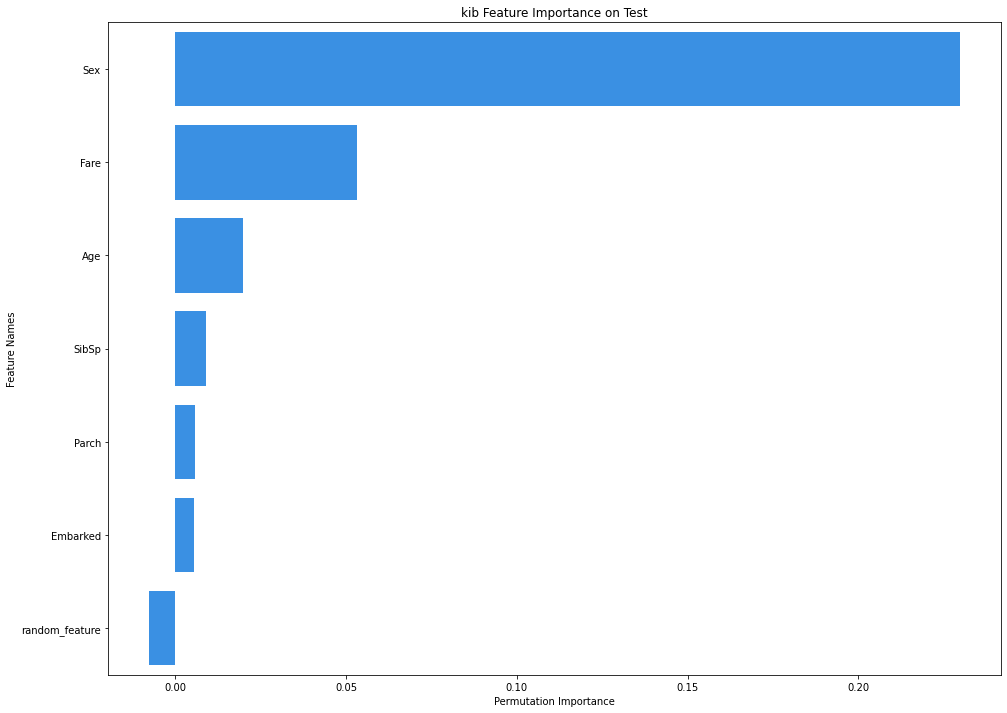

In [21]:
# Отрисовка топ факторов по Permutation Importance

feature_selection.permutation_plot(figsize=(16,12), top=10)

In [22]:
# Получаем факторы после анализа пермутейшн

features_after_permutation = feature_selection.select_features()

# Обновляем признаки
num_columns = list(filter(lambda x: x in features_after_permutation, num_columns))
cat_columns = list(filter(lambda x: x in features_after_permutation, cat_columns))

7 признаков было до Permutation Importance 

6 признаков после Permutation Importance от kib


## Расчет важностей по кросс-валидации

In [23]:
# Обновление пайплайна трансформации

prep_pipe = base_pipe(
    num_columns=num_columns, 
    cat_columns=cat_columns)

Определены количественные и категориальные переменные!


In [24]:
params = {
    'learning_rate':0.01,
    'n_estimators':1000,
    'subsample':0.9,
    'colsample_bytree':0.6,
    'max_depth':6,
    'objective':'binary',
    'n_jobs':-1,
    'random_state':42,
#    'eval_metric':'auc'
}

fit_params = {
    'early_stopping_rounds':100, 
    'eval_metric':['logloss', 'auc'],
    'verbose':25}

# создаем экземпляр класса LightGBM
lgb_model = lgb.LGBMClassifier(**params)

# задаем стратегию проверки
strat = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42)

In [25]:
model = AutoTrees(
    main_estimator=lgb_model, 
    main_fit_params=fit_params,
    main_prep_pipe = prep_pipe,
    main_features=num_columns+cat_columns,
    
    X_train=X_train,
    y_train=y_train,
    main_metric='roc_auc',
    model_type = 'lightboost')

In [26]:
model.model_fit_cv(strat=strat)

0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.589953	training's auc: 0.906817	valid_1's binary_logloss: 0.609775	valid_1's auc: 0.799242
[50]	training's binary_logloss: 0.535944	training's auc: 0.910901	valid_1's binary_logloss: 0.573216	valid_1's auc: 0.804113
[75]	training's binary_logloss: 0.499419	training's auc: 0.914704	valid_1's binary_logloss: 0.550314	valid_1's auc: 0.806006
[100]	training's binary_logloss: 0.470397	training's auc: 0.918055	valid_1's binary_logloss: 0.532513	valid_1's auc: 0.806277
[125]	training's binary_logloss: 0.444268	training's auc: 0.921159	valid_1's binary_logloss: 0.519534	valid_1's auc: 0.804924
[150]	training's binary_logloss: 0.42132	training's auc: 0.925508	valid_1's binary_logloss: 0.510116	valid_1's auc: 0.806818
[175]	training's binary_logloss: 0.401314	training's auc: 0.929678	valid_1's binary_logloss: 0.504647	valid_1's auc: 0.808577


1it [00:00,  2.39it/s]

BEST ITERATION:  292
roc_auc на обучающей выборке: 0.942
roc_auc на проверочной выборке: 0.814

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00,  3.09it/s]

Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.591816	training's auc: 0.898042	valid_1's binary_logloss: 0.611854	valid_1's auc: 0.818858
[50]	training's binary_logloss: 0.540522	training's auc: 0.901538	valid_1's binary_logloss: 0.573079	valid_1's auc: 0.825622
[75]	training's binary_logloss: 0.504854	training's auc: 0.906655	valid_1's binary_logloss: 0.548726	valid_1's auc: 0.827787
[100]	training's binary_logloss: 0.4769	training's auc: 0.910969	valid_1's binary_logloss: 0.531808	valid_1's auc: 0.822376
[125]	training's binary_logloss: 0.452804	training's auc: 0.913817	valid_1's binary_logloss: 0.520472	valid_1's auc: 0.821834
[150]	training's binary_logloss: 0.43185	training's auc: 0.917842	valid_1's binary_logloss: 0.51073	valid_1's auc: 0.823187
Early stopping, best iteration is:
[62]	training's binary_logloss: 0.522139	training's auc: 0.90413	valid_1's binary_logloss: 0.559152	valid_1's auc: 0.830222
BEST ITERATION:  62
roc_auc на

3it [00:00,  3.52it/s]

Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.590955	training's auc: 0.903193	valid_1's binary_logloss: 0.610347	valid_1's auc: 0.808306
[50]	training's binary_logloss: 0.539801	training's auc: 0.906032	valid_1's binary_logloss: 0.575237	valid_1's auc: 0.811282
[75]	training's binary_logloss: 0.504932	training's auc: 0.909136	valid_1's binary_logloss: 0.556011	valid_1's auc: 0.807224
[100]	training's binary_logloss: 0.476683	training's auc: 0.914627	valid_1's binary_logloss: 0.54321	valid_1's auc: 0.800189
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.647888	training's auc: 0.893617	valid_1's binary_logloss: 0.651673	valid_1's auc: 0.822511
BEST ITERATION:  5
roc_auc на обучающей выборке: 0.894
roc_auc на проверочной выборке: 0.823

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


4it [00:01,  3.32it/s]

Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.597072	training's auc: 0.893848	valid_1's binary_logloss: 0.589871	valid_1's auc: 0.906742
[50]	training's binary_logloss: 0.549254	training's auc: 0.896062	valid_1's binary_logloss: 0.539292	valid_1's auc: 0.908676
[75]	training's binary_logloss: 0.514555	training's auc: 0.901525	valid_1's binary_logloss: 0.505032	valid_1's auc: 0.909505
[100]	training's binary_logloss: 0.487361	training's auc: 0.904452	valid_1's binary_logloss: 0.477661	valid_1's auc: 0.911716
[125]	training's binary_logloss: 0.463596	training's auc: 0.90642	valid_1's binary_logloss: 0.454556	valid_1's auc: 0.910334
[150]	training's binary_logloss: 0.443671	training's auc: 0.908498	valid_1's binary_logloss: 0.434835	valid_1's auc: 0.912821
[175]	training's binary_logloss: 0.426696	training's auc: 0.911246	valid_1's binary_logloss: 0.419112	valid_1's auc: 0.913926
[200]	training's binary_logloss: 0.413731	training's auc: 0.

5it [00:01,  3.03it/s]

roc_auc на обучающей выборке: 0.926
roc_auc на проверочной выборке: 0.882

********************** 5 фолд обучен! ******************************




In [27]:
model.get_mean_cv_scores()

0.8526948642762612

In [28]:
model._best_iters

[292, 62, 5, 183, 334]

In [29]:
model.get_extra_scores()

names     fold_1     fold_2     fold_3     fold_4     fold_5
0   roc_train   0.942349   0.904130   0.893617   0.912671   0.926345
1   roc_valid   0.813718   0.830222   0.822511   0.915308   0.881716
2  gini_train  88.469738  80.826100  78.723332  82.534270  85.268920
3  gini_valid  62.743506  66.044372  64.502165  83.061619  76.343202

In [30]:
fi = model.get_fi()
fi

index  importance 0  importance 1  importance 2  importance 3  \
0       Sex   7328.200578   4154.415218    614.264999   5708.585296   
1      Fare   4421.256218   1988.561905    185.631396   3422.012508   
2       Age   2557.450129    570.727497     50.399496   1400.807308   
3     SibSp    703.131325    175.244465      0.387472    912.649102   
4  Embarked    516.750189    187.610401     17.398830    426.670977   
5     Parch    630.527875    112.069911     26.810920    363.492710   

   importance 4  mean_importance  
0   7005.819928      4962.257204  
1   3984.065096      2800.305424  
2   2479.065262      1411.689938  
3    688.212607       495.924994  
4    576.845736       345.055226  
5    568.025912       340.185466

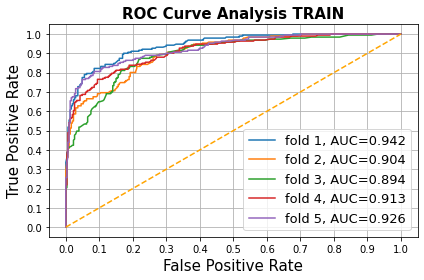

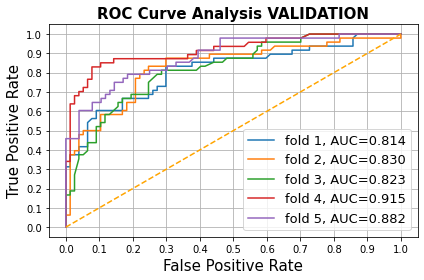

In [31]:
model.get_rocauc_plots()

In [32]:
model.get_curve_plots()

## Жадные отборы Forward и Backward selection

In [33]:
selection = AutoSelection(base_pipe=base_pipe,
                          num_columns=num_columns,
                          cat_columns=cat_columns,
                          main_fit_params=fit_params,
                          main_estimator=lgb_model,
                          
                          X_train=X_train,
                          y_train=y_train,
                          main_metric='roc_auc',
                          model_type='lightboost')

Определены количественные и категориальные переменные!


In [34]:
fselection_res = selection.forward_selection(strat=strat)

Определены количественные и категориальные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.589953	training's auc: 0.906817	valid_1's binary_logloss: 0.609775	valid_1's auc: 0.799242
[50]	training's binary_logloss: 0.535944	training's auc: 0.910901	valid_1's binary_logloss: 0.573216	valid_1's auc: 0.804113
[75]	training's binary_logloss: 0.499419	training's auc: 0.914704	valid_1's binary_logloss: 0.550314	valid_1's auc: 0.806006
[100]	training's binary_logloss: 0.470397	training's auc: 0.918055	valid_1's binary_logloss: 0.532513	valid_1's auc: 0.806277
[125]	training's binary_logloss: 0.444268	training's auc: 0.921159	valid_1's binary_logloss: 0.519534	valid_1's auc: 0.804924
[150]	training's binary_logloss: 0.42132	training's auc: 0.925508	valid_1's binary_logloss: 0.510116	valid_1's auc: 0.806818
[175]	training's binary_logloss: 0.401314	training's auc: 0.929678	valid_1's binary_logloss: 0.504647	valid_1's auc: 0.808577


1it [00:00,  1.55it/s]

roc_auc на обучающей выборке: 0.942
roc_auc на проверочной выборке: 0.814

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.591816	training's auc: 0.898042	valid_1's binary_logloss: 0.611854	valid_1's auc: 0.818858
[50]	training's binary_logloss: 0.540522	training's auc: 0.901538	valid_1's binary_logloss: 0.573079	valid_1's auc: 0.825622


2it [00:00,  2.13it/s]

[75]	training's binary_logloss: 0.504854	training's auc: 0.906655	valid_1's binary_logloss: 0.548726	valid_1's auc: 0.827787
[100]	training's binary_logloss: 0.4769	training's auc: 0.910969	valid_1's binary_logloss: 0.531808	valid_1's auc: 0.822376
[125]	training's binary_logloss: 0.452804	training's auc: 0.913817	valid_1's binary_logloss: 0.520472	valid_1's auc: 0.821834
[150]	training's binary_logloss: 0.43185	training's auc: 0.917842	valid_1's binary_logloss: 0.51073	valid_1's auc: 0.823187
Early stopping, best iteration is:
[62]	training's binary_logloss: 0.522139	training's auc: 0.90413	valid_1's binary_logloss: 0.559152	valid_1's auc: 0.830222
BEST ITERATION:  62
roc_auc на обучающей выборке: 0.904
roc_auc на проверочной выборке: 0.830

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================


3it [00:01,  2.65it/s]

Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.590955	training's auc: 0.903193	valid_1's binary_logloss: 0.610347	valid_1's auc: 0.808306
[50]	training's binary_logloss: 0.539801	training's auc: 0.906032	valid_1's binary_logloss: 0.575237	valid_1's auc: 0.811282
[75]	training's binary_logloss: 0.504932	training's auc: 0.909136	valid_1's binary_logloss: 0.556011	valid_1's auc: 0.807224
[100]	training's binary_logloss: 0.476683	training's auc: 0.914627	valid_1's binary_logloss: 0.54321	valid_1's auc: 0.800189
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.647888	training's auc: 0.893617	valid_1's binary_logloss: 0.651673	valid_1's auc: 0.822511
BEST ITERATION:  5
roc_auc на обучающей выборке: 0.894
roc_auc на проверочной выборке: 0.823

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
Training until validation scores don't improve for 100

4it [00:01,  2.26it/s]

[175]	training's binary_logloss: 0.426696	training's auc: 0.911246	valid_1's binary_logloss: 0.419112	valid_1's auc: 0.913926
[200]	training's binary_logloss: 0.413731	training's auc: 0.91469	valid_1's binary_logloss: 0.409897	valid_1's auc: 0.913926
[225]	training's binary_logloss: 0.401564	training's auc: 0.917786	valid_1's binary_logloss: 0.401257	valid_1's auc: 0.912407
[250]	training's binary_logloss: 0.391167	training's auc: 0.920043	valid_1's binary_logloss: 0.393399	valid_1's auc: 0.911301
[275]	training's binary_logloss: 0.382728	training's auc: 0.922359	valid_1's binary_logloss: 0.387403	valid_1's auc: 0.913236
Early stopping, best iteration is:
[183]	training's binary_logloss: 0.422401	training's auc: 0.912671	valid_1's binary_logloss: 0.416201	valid_1's auc: 0.915308
BEST ITERATION:  183
roc_auc на обучающей выборке: 0.913
roc_auc на проверочной выборке: 0.915

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====

5it [00:02,  1.68it/s]


roc_auc на обучающей выборке: 0.926
roc_auc на проверочной выборке: 0.882

********************** 5 фолд обучен! ******************************


Средняя метрика на фолдах со всеми факторами:  0.852695
Конец обуения кросс-валидации!

Начало жадного отбора факторов Forward Selection!
Добавление признака Sex
Определены только категориальные переменные!


1it [00:00,  7.83it/s]

==================== Обучение 1 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.602265	training's auc: 0.779764	valid_1's binary_logloss: 0.613851	valid_1's auc: 0.734578
[50]	training's binary_logloss: 0.563651	training's auc: 0.779764	valid_1's binary_logloss: 0.58394	valid_1's auc: 0.734578
[75]	training's binary_logloss: 0.539579	training's auc: 0.779764	valid_1's binary_logloss: 0.566737	valid_1's auc: 0.734578
[100]	training's binary_logloss: 0.524431	training's auc: 0.779764	valid_1's binary_logloss: 0.557081	valid_1's auc: 0.734578
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.662536	training's auc: 0.779764	valid_1's binary_logloss: 0.663281	valid_1's auc: 0.734578
BEST ITERATION:  1
roc_auc на обучающей выборке: 0.780
roc_auc на проверочной выборке: 0.735

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ===============

2it [00:00,  8.74it/s]

[100]	training's binary_logloss: 0.5354	training's auc: 0.768653	valid_1's binary_logloss: 0.527906	valid_1's auc: 0.778815
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.66278	training's auc: 0.768653	valid_1's binary_logloss: 0.662886	valid_1's auc: 0.778815
BEST ITERATION:  1
roc_auc на обучающей выборке: 0.769
roc_auc на проверочной выборке: 0.779

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.603428	training's auc: 0.776157	valid_1's binary_logloss: 0.610683	valid_1's auc: 0.748918
[50]	training's binary_logloss: 0.565563	training's auc: 0.776157	valid_1's binary_logloss: 0.578507	valid_1's auc: 0.748918
[75]	training's binary_logloss: 0.541979	training's auc: 0.776157	valid_1's binary_logloss: 0.559589	valid_1's auc: 0.748918
[100]	training's binary_logloss: 0.527148	training's auc

4it [00:00, 10.72it/s]

roc_auc на обучающей выборке: 0.757
roc_auc на проверочной выборке: 0.827

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:00, 10.24it/s]


Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.604862	training's auc: 0.772132	valid_1's binary_logloss: 0.608652	valid_1's auc: 0.764803
[50]	training's binary_logloss: 0.568122	training's auc: 0.772132	valid_1's binary_logloss: 0.573518	valid_1's auc: 0.764803
[75]	training's binary_logloss: 0.545269	training's auc: 0.772132	valid_1's binary_logloss: 0.552096	valid_1's auc: 0.764803
[100]	training's binary_logloss: 0.53092	training's auc: 0.772132	valid_1's binary_logloss: 0.538988	valid_1's auc: 0.764803
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.662319	training's auc: 0.772132	valid_1's binary_logloss: 0.664458	valid_1's auc: 0.764803
BEST ITERATION:  1
roc_auc на обучающей выборке: 0.772
roc_auc на проверочной выборке: 0.765

********************** 5 фолд обучен! ******************************


Количество признаков: 1 => метрика: 0.7707998235433846
Добавление признака Fare
Определены количественные и катего

0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.623581	training's auc: 0.76722	valid_1's binary_logloss: 0.63328	valid_1's auc: 0.694535
[50]	training's binary_logloss: 0.597213	training's auc: 0.769292	valid_1's binary_logloss: 0.617562	valid_1's auc: 0.693182
[75]	training's binary_logloss: 0.579409	training's auc: 0.772055	valid_1's binary_logloss: 0.610059	valid_1's auc: 0.695076
[100]	training's binary_logloss: 0.56654	training's auc: 0.773155	valid_1's binary_logloss: 0.602957	valid_1's auc: 0.69697
[125]	training's binary_logloss: 0.557909	training's auc: 0.776447	valid_1's binary_logloss: 0.600315	valid_1's auc: 0.696293
[150]	training's binary_logloss: 0.551422	training's auc: 0.778996	valid_1's binary_logloss: 0.59936	valid_1's auc: 0.700622
[175]	training's binary_logloss: 0.546347	training's auc: 0.78505	valid_1's binary_logloss: 0.599163	valid_1's auc: 0.708198
[200]

1it [00:00,  3.67it/s]

[325]	training's binary_logloss: 0.528628	training's auc: 0.797201	valid_1's binary_logloss: 0.59782	valid_1's auc: 0.720238
[350]	training's binary_logloss: 0.526602	training's auc: 0.800783	valid_1's binary_logloss: 0.598838	valid_1's auc: 0.722944
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.533821	training's auc: 0.793236	valid_1's binary_logloss: 0.595907	valid_1's auc: 0.718344
BEST ITERATION:  266
roc_auc на обучающей выборке: 0.793
roc_auc на проверочной выборке: 0.718

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.622054	training's auc: 0.774502	valid_1's binary_logloss: 0.645127	valid_1's auc: 0.663826
[50]	training's binary_logloss: 0.594269	training's auc: 0.777393	valid_1's binary_logloss: 0.633564	valid_1's auc: 0.663149
[75]	training's binary_logloss: 0.575094	training

2it [00:00,  4.37it/s]

[200]	training's binary_logloss: 0.534551	training's auc: 0.799956	valid_1's binary_logloss: 0.630805	valid_1's auc: 0.68033
Early stopping, best iteration is:
[118]	training's binary_logloss: 0.55546	training's auc: 0.786184	valid_1's binary_logloss: 0.623616	valid_1's auc: 0.686147
BEST ITERATION:  118
roc_auc на обучающей выборке: 0.786
roc_auc на проверочной выборке: 0.686

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.620912	training's auc: 0.774485	valid_1's binary_logloss: 0.65277	valid_1's auc: 0.619183
[50]	training's binary_logloss: 0.593341	training's auc: 0.776822	valid_1's binary_logloss: 0.645761	valid_1's auc: 0.631223
[75]	training's binary_logloss: 0.575655	training's auc: 0.780727	valid_1's binary_logloss: 0.641503	valid_1's auc: 0.637581
[100]	training's binary_logloss: 0.563927	training's

3it [00:00,  4.89it/s]

roc_auc на обучающей выборке: 0.783
roc_auc на проверочной выборке: 0.645

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.626607	training's auc: 0.760094	valid_1's binary_logloss: 0.62052	valid_1's auc: 0.767892
[50]	training's binary_logloss: 0.601666	training's auc: 0.76051	valid_1's binary_logloss: 0.595787	valid_1's auc: 0.770517
[75]	training's binary_logloss: 0.585603	training's auc: 0.767576	valid_1's binary_logloss: 0.580717	valid_1's auc: 0.768721
[100]	training's binary_logloss: 0.57387	training's auc: 0.7718	valid_1's binary_logloss: 0.570852	valid_1's auc: 0.761813
[125]	training's binary_logloss: 0.565347	training's auc: 0.775295	valid_1's binary_logloss: 0.565181	valid_1's auc: 0.764438
[150]	training's binary_logloss: 0.559421	training's auc: 0.774973	valid_1's binary_logloss: 0.561188	valid_1'

4it [00:00,  5.42it/s]

roc_auc на обучающей выборке: 0.763
roc_auc на проверочной выборке: 0.776

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.624625	training's auc: 0.760114	valid_1's binary_logloss: 0.630849	valid_1's auc: 0.700795
[50]	training's binary_logloss: 0.599137	training's auc: 0.764457	valid_1's binary_logloss: 0.608654	valid_1's auc: 0.700521
[75]	training's binary_logloss: 0.582625	training's auc: 0.767084	valid_1's binary_logloss: 0.597976	valid_1's auc: 0.704084
[100]	training's binary_logloss: 0.571664	training's auc: 0.768954	valid_1's binary_logloss: 0.591061	valid_1's auc: 0.71176
[125]	training's binary_logloss: 0.56404	training's auc: 0.773169	valid_1's binary_logloss: 0.584844	valid_1's auc: 0.729989
[150]	training's binary_logloss: 0.558452	training's auc: 0.774283	valid_1's binary_logloss: 0.581772	valid

5it [00:01,  4.52it/s]


BEST ITERATION:  375
roc_auc на обучающей выборке: 0.784
roc_auc на проверочной выборке: 0.751

********************** 5 фолд обучен! ******************************


Количество признаков: 2 => метрика: 0.7152469089794118
Добавление признака Age
Определены количественные и категориальные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.582804	training's auc: 0.87108	valid_1's binary_logloss: 0.602304	valid_1's auc: 0.800866
[50]	training's binary_logloss: 0.530621	training's auc: 0.87374	valid_1's binary_logloss: 0.56278	valid_1's auc: 0.807359
[75]	training's binary_logloss: 0.495231	training's auc: 0.876401	valid_1's binary_logloss: 0.538412	valid_1's auc: 0.806006
[100]	training's binary_logloss: 0.469915	training's auc: 0.880383	valid_1's binary_logloss: 0.523917	valid_1's auc: 0.807224
[125]	training's binary_logloss: 0.451792	training's auc: 0.881184	valid_1's binary_logloss: 0.514934	valid_1's auc: 0.806142
[150]	training's binary_logloss: 0.438363	training's auc: 0.883589	valid_1's binary_logloss: 0.508406	valid_1's auc: 0.806412
Early stopping, best iteration is:
[51]	training's binary_logloss: 0.528994	training's auc: 0.874968	valid_1's binary_logloss: 0

1it [00:00,  5.76it/s]

roc_auc на обучающей выборке: 0.875
roc_auc на проверочной выборке: 0.817

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.584436	training's auc: 0.868632	valid_1's binary_logloss: 0.596823	valid_1's auc: 0.825352
[50]	training's binary_logloss: 0.532928	training's auc: 0.869664	valid_1's binary_logloss: 0.554508	valid_1's auc: 0.825352
[75]	training's binary_logloss: 0.498676	training's auc: 0.871873	valid_1's binary_logloss: 0.528416	valid_1's auc: 0.828598
[100]	training's binary_logloss: 0.475009	training's auc: 0.876605	valid_1's binary_logloss: 0.511642	valid_1's auc: 0.832927
[125]	training's binary_logloss: 0.457567	training's auc: 0.87797	valid_1's binary_logloss: 0.500609	valid_1's auc: 0.833333
[150]	training's binary_logloss: 0.444362	training's auc: 0.879445	valid_1's binary_logloss: 0.493792	vali

2it [00:00,  5.43it/s]

Early stopping, best iteration is:
[95]	training's binary_logloss: 0.479164	training's auc: 0.876537	valid_1's binary_logloss: 0.514439	valid_1's auc: 0.837662
BEST ITERATION:  95
roc_auc на обучающей выборке: 0.877
roc_auc на проверочной выборке: 0.838

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.581722	training's auc: 0.880332	valid_1's binary_logloss: 0.598612	valid_1's auc: 0.792073
[50]	training's binary_logloss: 0.527901	training's auc: 0.881918	valid_1's binary_logloss: 0.560059	valid_1's auc: 0.795725
[75]	training's binary_logloss: 0.492621	training's auc: 0.885618	valid_1's binary_logloss: 0.536142	valid_1's auc: 0.794372
[100]	training's binary_logloss: 0.468184	training's auc: 0.888006	valid_1's binary_logloss: 0.521527	valid_1's auc: 0.796402
[125]	training's binary_logloss: 0.450695	training'

3it [00:00,  4.95it/s]

Early stopping, best iteration is:
[143]	training's binary_logloss: 0.441017	training's auc: 0.89059	valid_1's binary_logloss: 0.509994	valid_1's auc: 0.80506
BEST ITERATION:  143
roc_auc на обучающей выборке: 0.891
roc_auc на проверочной выборке: 0.805

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.591738	training's auc: 0.858264	valid_1's binary_logloss: 0.576727	valid_1's auc: 0.879801
[50]	training's binary_logloss: 0.544785	training's auc: 0.862556	valid_1's binary_logloss: 0.522793	valid_1's auc: 0.882426
[75]	training's binary_logloss: 0.513407	training's auc: 0.862598	valid_1's binary_logloss: 0.485175	valid_1's auc: 0.885742
[100]	training's binary_logloss: 0.491528	training's auc: 0.863328	valid_1's binary_logloss: 0.458128	valid_1's auc: 0.887124
[125]	training's binary_logloss: 0.475808	training'

4it [00:00,  5.10it/s]

roc_auc на обучающей выборке: 0.863
roc_auc на проверочной выборке: 0.888

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.587744	training's auc: 0.862157	valid_1's binary_logloss: 0.593129	valid_1's auc: 0.853755
[50]	training's binary_logloss: 0.538405	training's auc: 0.865209	valid_1's binary_logloss: 0.54623	valid_1's auc: 0.870614
[75]	training's binary_logloss: 0.505255	training's auc: 0.866271	valid_1's binary_logloss: 0.515313	valid_1's auc: 0.873081
[100]	training's binary_logloss: 0.482126	training's auc: 0.866144	valid_1's binary_logloss: 0.493679	valid_1's auc: 0.874452
[125]	training's binary_logloss: 0.465548	training's auc: 0.867351	valid_1's binary_logloss: 0.478344	valid_1's auc: 0.878289
[150]	training's binary_logloss: 0.453505	training's auc: 0.8673	valid_1's binary_logloss: 0.467323	valid_

5it [00:00,  5.08it/s]


roc_auc на обучающей выборке: 0.867
roc_auc на проверочной выборке: 0.878

********************** 5 фолд обучен! ******************************


Количество признаков: 3 => метрика: 0.845212675062899
Добавление признака SibSp
Определены количественные и категориальные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.615293	training's auc: 0.886386	valid_1's binary_logloss: 0.640298	valid_1's auc: 0.69494
[50]	training's binary_logloss: 0.568477	training's auc: 0.908906	valid_1's binary_logloss: 0.61447	valid_1's auc: 0.724838
[75]	training's binary_logloss: 0.534461	training's auc: 0.912777	valid_1's binary_logloss: 0.598248	valid_1's auc: 0.728355
[100]	training's binary_logloss: 0.505487	training's auc: 0.915923	valid_1's binary_logloss: 0.584833	valid_1's auc: 0.737689
[125]	training's binary_logloss: 0.477684	training's auc: 0.919505	valid_1's binary_logloss: 0.570344	valid_1's auc: 0.745265
[150]	training's binary_logloss: 0.454578	training's auc: 0.921628	valid_1's binary_logloss: 0.559043	valid_1's auc: 0.755141
[175]	training's binary_logloss: 0.437153	training's auc: 0.924638	valid_1's binary_logloss: 0.554915	valid_1's auc: 0.756494
[

1it [00:00,  2.54it/s]

BEST ITERATION:  420
roc_auc на обучающей выборке: 0.942
roc_auc на проверочной выборке: 0.778

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.623164	training's auc: 0.862561	valid_1's binary_logloss: 0.627985	valid_1's auc: 0.837662
[50]	training's binary_logloss: 0.579846	training's auc: 0.884425	valid_1's binary_logloss: 0.598208	valid_1's auc: 0.842262
[75]	training's binary_logloss: 0.546973	training's auc: 0.899705	valid_1's binary_logloss: 0.579182	valid_1's auc: 0.837662
[100]	training's binary_logloss: 0.518807	training's auc: 0.905333	valid_1's binary_logloss: 0.560851	valid_1's auc: 0.835227
[125]	training's binary_logloss: 0.492378	training's auc: 0.911029	valid_1's binary_logloss: 0.547796	valid_1's auc: 0.837933
Early stopping, best iteration is:
[34]	training's binary_logloss: 0.608165	training

2it [00:00,  3.84it/s]

roc_auc на обучающей выборке: 0.877
roc_auc на проверочной выборке: 0.847

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.624371	training's auc: 0.852465	valid_1's binary_logloss: 0.635801	valid_1's auc: 0.791126
[50]	training's binary_logloss: 0.582834	training's auc: 0.879675	valid_1's binary_logloss: 0.608838	valid_1's auc: 0.79816
[75]	training's binary_logloss: 0.553986	training's auc: 0.886462	valid_1's binary_logloss: 0.591409	valid_1's auc: 0.796537
[100]	training's binary_logloss: 0.528437	training's auc: 0.891741	valid_1's binary_logloss: 0.572842	valid_1's auc: 0.798295
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.66223	training's auc: 0.829698	valid_1's binary_logloss: 0.662739	valid_1's auc: 0.813041
BEST ITERATION:  1


3it [00:00,  4.86it/s]

roc_auc на обучающей выборке: 0.830
roc_auc на проверочной выборке: 0.813

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.620854	training's auc: 0.861521	valid_1's binary_logloss: 0.627422	valid_1's auc: 0.811412
[50]	training's binary_logloss: 0.5794	training's auc: 0.882634	valid_1's binary_logloss: 0.587383	valid_1's auc: 0.855899
[75]	training's binary_logloss: 0.548864	training's auc: 0.88786	valid_1's binary_logloss: 0.559811	valid_1's auc: 0.864742
[100]	training's binary_logloss: 0.522762	training's auc: 0.891643	valid_1's binary_logloss: 0.534469	valid_1's auc: 0.873308
[125]	training's binary_logloss: 0.500072	training's auc: 0.895655	valid_1's binary_logloss: 0.51184	valid_1's auc: 0.876623
[150]	training's binary_logloss: 0.480312	training's auc: 0.897394	valid_1's binary_logloss: 0.491813	valid_1

4it [00:01,  3.89it/s]

BEST ITERATION:  414
roc_auc на обучающей выборке: 0.925
roc_auc на проверочной выборке: 0.891

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.622943	training's auc: 0.858647	valid_1's binary_logloss: 0.632812	valid_1's auc: 0.778235
[50]	training's binary_logloss: 0.581009	training's auc: 0.882403	valid_1's binary_logloss: 0.598638	valid_1's auc: 0.817023
[75]	training's binary_logloss: 0.55191	training's auc: 0.887409	valid_1's binary_logloss: 0.575536	valid_1's auc: 0.824836
[100]	training's binary_logloss: 0.526023	training's auc: 0.893673	valid_1's binary_logloss: 0.557612	valid_1's auc: 0.821683
[125]	training's binary_logloss: 0.502467	training's auc: 0.899121	valid_1's binary_logloss: 0.540208	valid_1's auc: 0.82881
[150]	training's binary_logloss: 0.482553	training's auc: 0.901136	valid_1's binary_lo

5it [00:01,  3.98it/s]


[200]	training's binary_logloss: 0.455783	training's auc: 0.904221	valid_1's binary_logloss: 0.510013	valid_1's auc: 0.827851
[225]	training's binary_logloss: 0.445567	training's auc: 0.906201	valid_1's binary_logloss: 0.504137	valid_1's auc: 0.828399
Early stopping, best iteration is:
[138]	training's binary_logloss: 0.489562	training's auc: 0.900456	valid_1's binary_logloss: 0.530694	valid_1's auc: 0.8321
BEST ITERATION:  138
roc_auc на обучающей выборке: 0.900
roc_auc на проверочной выборке: 0.832

********************** 5 фолд обучен! ******************************


Количество признаков: 4 => метрика: 0.8320354576601078
Добавление признака Embarked
Определены количественные и категориальные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.599268	training's auc: 0.905734	valid_1's binary_logloss: 0.617924	valid_1's auc: 0.793019
[50]	training's binary_logloss: 0.546276	training's auc: 0.911404	valid_1's binary_logloss: 0.581991	valid_1's auc: 0.805195
[75]	training's binary_logloss: 0.508329	training's auc: 0.913519	valid_1's binary_logloss: 0.557266	valid_1's auc: 0.805465
[100]	training's binary_logloss: 0.475671	training's auc: 0.91768	valid_1's binary_logloss: 0.536658	valid_1's auc: 0.809524
[125]	training's binary_logloss: 0.451026	training's auc: 0.923188	valid_1's binary_logloss: 0.523662	valid_1's auc: 0.80993
[150]	training's binary_logloss: 0.428445	training's auc: 0.926838	valid_1's binary_logloss: 0.513608	valid_1's auc: 0.811824
[175]	training's binary_logloss: 0.409677	training's auc: 0.930897	valid_1's binary_logloss: 0.505118	valid_1's auc: 0.8148
[20

1it [00:00,  2.48it/s]

BEST ITERATION:  339
roc_auc на обучающей выборке: 0.947
roc_auc на проверочной выборке: 0.820

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.602282	training's auc: 0.897718	valid_1's binary_logloss: 0.620022	valid_1's auc: 0.82224
[50]	training's binary_logloss: 0.552224	training's auc: 0.903133	valid_1's binary_logloss: 0.584826	valid_1's auc: 0.819805
[75]	training's binary_logloss: 0.514395	training's auc: 0.908249	valid_1's binary_logloss: 0.563021	valid_1's auc: 0.8102


2it [00:00,  3.51it/s]

[100]	training's binary_logloss: 0.482196	training's auc: 0.912794	valid_1's binary_logloss: 0.539726	valid_1's auc: 0.820211
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.651525	training's auc: 0.883418	valid_1's binary_logloss: 0.654298	valid_1's auc: 0.84375
BEST ITERATION:  5
roc_auc на обучающей выборке: 0.883
roc_auc на проверочной выборке: 0.844

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.601878	training's auc: 0.904361	valid_1's binary_logloss: 0.620311	valid_1's auc: 0.808442
[50]	training's binary_logloss: 0.551356	training's auc: 0.908496	valid_1's binary_logloss: 0.586399	valid_1's auc: 0.802489
[75]	training's binary_logloss: 0.513679	training's auc: 0.914909	valid_1's binary_logloss: 0.563623	valid_1's auc: 0.803707
[100]	training's binary_logloss: 0.483229	training's a

3it [00:00,  4.06it/s]

Early stopping, best iteration is:
[9]	training's binary_logloss: 0.640899	training's auc: 0.8929	valid_1's binary_logloss: 0.647385	valid_1's auc: 0.818723
BEST ITERATION:  9
roc_auc на обучающей выборке: 0.893
roc_auc на проверочной выборке: 0.819

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.606564	training's auc: 0.895519	valid_1's binary_logloss: 0.603311	valid_1's auc: 0.898176
[50]	training's binary_logloss: 0.557822	training's auc: 0.900931	valid_1's binary_logloss: 0.555716	valid_1's auc: 0.896242
[75]	training's binary_logloss: 0.521211	training's auc: 0.904664	valid_1's binary_logloss: 0.519803	valid_1's auc: 0.900663
[100]	training's binary_logloss: 0.490127	training's auc: 0.908176	valid_1's binary_logloss: 0.488799	valid_1's auc: 0.906466
[125]	training's binary_logloss: 0.466584	training's au

4it [00:01,  4.02it/s]

[150]	training's binary_logloss: 0.446788	training's auc: 0.915717	valid_1's binary_logloss: 0.451451	valid_1's auc: 0.907433
[175]	training's binary_logloss: 0.430327	training's auc: 0.918168	valid_1's binary_logloss: 0.437057	valid_1's auc: 0.908262
[200]	training's binary_logloss: 0.416577	training's auc: 0.921578	valid_1's binary_logloss: 0.427559	valid_1's auc: 0.905222
Early stopping, best iteration is:
[108]	training's binary_logloss: 0.482461	training's auc: 0.910593	valid_1's binary_logloss: 0.482973	valid_1's auc: 0.908676
BEST ITERATION:  108
roc_auc на обучающей выборке: 0.911
roc_auc на проверочной выборке: 0.909

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.603929	training's auc: 0.892891	valid_1's binary_logloss: 0.612598	valid_1's auc: 0.865817


5it [00:01,  3.85it/s]


[50]	training's binary_logloss: 0.555348	training's auc: 0.897625	valid_1's binary_logloss: 0.570788	valid_1's auc: 0.869106
[75]	training's binary_logloss: 0.51932	training's auc: 0.900354	valid_1's binary_logloss: 0.541437	valid_1's auc: 0.864309
[100]	training's binary_logloss: 0.489692	training's auc: 0.903286	valid_1's binary_logloss: 0.51818	valid_1's auc: 0.865954
[125]	training's binary_logloss: 0.468092	training's auc: 0.907238	valid_1's binary_logloss: 0.502213	valid_1's auc: 0.865543
[150]	training's binary_logloss: 0.44836	training's auc: 0.910179	valid_1's binary_logloss: 0.486715	valid_1's auc: 0.868558
Early stopping, best iteration is:
[53]	training's binary_logloss: 0.548901	training's auc: 0.89737	valid_1's binary_logloss: 0.565148	valid_1's auc: 0.869929
BEST ITERATION:  53
roc_auc на обучающей выборке: 0.897
roc_auc на проверочной выборке: 0.870

********************** 5 фолд обучен! ******************************


Количество признаков: 5 => метрика: 0.852203715587

0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.591127	training's auc: 0.904275	valid_1's binary_logloss: 0.611355	valid_1's auc: 0.793696
[50]	training's binary_logloss: 0.537761	training's auc: 0.908334	valid_1's binary_logloss: 0.575074	valid_1's auc: 0.796672
[75]	training's binary_logloss: 0.501982	training's auc: 0.912112	valid_1's binary_logloss: 0.553579	valid_1's auc: 0.797619
[100]	training's binary_logloss: 0.472854	training's auc: 0.916981	valid_1's binary_logloss: 0.537027	valid_1's auc: 0.804383
[125]	training's binary_logloss: 0.447145	training's auc: 0.919581	valid_1's binary_logloss: 0.523056	valid_1's auc: 0.80763
[150]	training's binary_logloss: 0.424128	training's auc: 0.924485	valid_1's binary_logloss: 0.513594	valid_1's auc: 0.805465
[175]	training's binary_logloss: 0.403795	training's auc: 0.929072	valid_1's binary_logloss: 0.506739	valid_1's auc: 0.807359


1it [00:00,  2.67it/s]

roc_auc на обучающей выборке: 0.940
roc_auc на проверочной выборке: 0.813

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.592344	training's auc: 0.899696	valid_1's binary_logloss: 0.61118	valid_1's auc: 0.82197
[50]	training's binary_logloss: 0.541165	training's auc: 0.901513	valid_1's binary_logloss: 0.573806	valid_1's auc: 0.822781
[75]	training's binary_logloss: 0.506528	training's auc: 0.905043	valid_1's binary_logloss: 0.551439	valid_1's auc: 0.822646
[100]	training's binary_logloss: 0.478979	training's auc: 0.910057	valid_1's binary_logloss: 0.533622	valid_1's auc: 0.826975
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.657633	training's auc: 0.870943	valid_1's binary_logloss: 0.658895	valid_1's auc: 0.840368
BEST ITERATION:  2


2it [00:00,  3.63it/s]

roc_auc на обучающей выборке: 0.871
roc_auc на проверочной выборке: 0.840

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.592468	training's auc: 0.900669	valid_1's binary_logloss: 0.610802	valid_1's auc: 0.816423
[50]	training's binary_logloss: 0.540161	training's auc: 0.906194	valid_1's binary_logloss: 0.575104	valid_1's auc: 0.813447
[75]	training's binary_logloss: 0.50581	training's auc: 0.908582	valid_1's binary_logloss: 0.556786	valid_1's auc: 0.808306
[100]	training's binary_logloss: 0.479122	training's auc: 0.911685	valid_1's binary_logloss: 0.543796	valid_1's auc: 0.80506
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.651984	training's auc: 0.889362	valid_1's binary_logloss: 0.655005	valid_1's auc: 0.82454
BEST ITERATION:  4


3it [00:00,  4.06it/s]

roc_auc на обучающей выборке: 0.889
roc_auc на проверочной выборке: 0.825

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.598619	training's auc: 0.890922	valid_1's binary_logloss: 0.593296	valid_1's auc: 0.896242
[50]	training's binary_logloss: 0.549879	training's auc: 0.893798	valid_1's binary_logloss: 0.541879	valid_1's auc: 0.901216
[75]	training's binary_logloss: 0.515315	training's auc: 0.899617	valid_1's binary_logloss: 0.507873	valid_1's auc: 0.901768
[100]	training's binary_logloss: 0.488577	training's auc: 0.904274	valid_1's binary_logloss: 0.481532	valid_1's auc: 0.903426
[125]	training's binary_logloss: 0.464828	training's auc: 0.905936	valid_1's binary_logloss: 0.456766	valid_1's auc: 0.907295


4it [00:01,  3.54it/s]

[150]	training's binary_logloss: 0.444342	training's auc: 0.908566	valid_1's binary_logloss: 0.436994	valid_1's auc: 0.910058
[175]	training's binary_logloss: 0.426775	training's auc: 0.910941	valid_1's binary_logloss: 0.420375	valid_1's auc: 0.910611
[200]	training's binary_logloss: 0.414188	training's auc: 0.914376	valid_1's binary_logloss: 0.410948	valid_1's auc: 0.911716
[225]	training's binary_logloss: 0.401645	training's auc: 0.918168	valid_1's binary_logloss: 0.401652	valid_1's auc: 0.912683
[250]	training's binary_logloss: 0.391082	training's auc: 0.920654	valid_1's binary_logloss: 0.393861	valid_1's auc: 0.912683
[275]	training's binary_logloss: 0.382271	training's auc: 0.923037	valid_1's binary_logloss: 0.389304	valid_1's auc: 0.911301
[300]	training's binary_logloss: 0.37398	training's auc: 0.924751	valid_1's binary_logloss: 0.385252	valid_1's auc: 0.910196
[325]	training's binary_logloss: 0.366429	training's auc: 0.927143	valid_1's binary_logloss: 0.383013	valid_1's auc: 0.

5it [00:01,  3.76it/s]

Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.595562	training's auc: 0.889797	valid_1's binary_logloss: 0.606271	valid_1's auc: 0.867325
[50]	training's binary_logloss: 0.545673	training's auc: 0.892407	valid_1's binary_logloss: 0.564072	valid_1's auc: 0.868147
[75]	training's binary_logloss: 0.51292	training's auc: 0.89454	valid_1's binary_logloss: 0.539325	valid_1's auc: 0.86102
[100]	training's binary_logloss: 0.486975	training's auc: 0.898628	valid_1's binary_logloss: 0.5212	valid_1's auc: 0.858964
Early stopping, best iteration is:
[13]	training's binary_logloss: 0.626095	training's auc: 0.887656	valid_1's binary_logloss: 0.632552	valid_1's auc: 0.871025
BEST ITERATION:  13
roc_auc на обучающей выборке: 0.888
roc_auc на проверочной выборке: 0.871

********************** 5 фолд обучен! ******************************


Количество признаков: 6 => метрика: 0.8525254822864705

Количество отобранных признаков: 6
Метрика до отбора: 0.8527

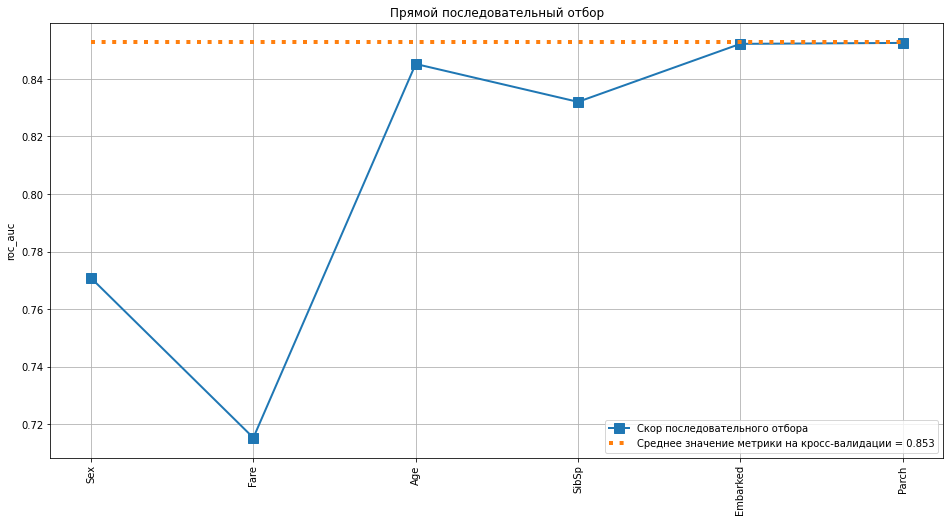

In [35]:
selection.plot_forward(figsize=(16,8))

In [36]:
bselection_res = selection.backward_selection(strat=strat,first_degradation=False)

Определены количественные и категориальные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.589953	training's auc: 0.906817	valid_1's binary_logloss: 0.609775	valid_1's auc: 0.799242
[50]	training's binary_logloss: 0.535944	training's auc: 0.910901	valid_1's binary_logloss: 0.573216	valid_1's auc: 0.804113
[75]	training's binary_logloss: 0.499419	training's auc: 0.914704	valid_1's binary_logloss: 0.550314	valid_1's auc: 0.806006
[100]	training's binary_logloss: 0.470397	training's auc: 0.918055	valid_1's binary_logloss: 0.532513	valid_1's auc: 0.806277


1it [00:00,  2.56it/s]

[125]	training's binary_logloss: 0.444268	training's auc: 0.921159	valid_1's binary_logloss: 0.519534	valid_1's auc: 0.804924
[150]	training's binary_logloss: 0.42132	training's auc: 0.925508	valid_1's binary_logloss: 0.510116	valid_1's auc: 0.806818
[175]	training's binary_logloss: 0.401314	training's auc: 0.929678	valid_1's binary_logloss: 0.504647	valid_1's auc: 0.808577
[200]	training's binary_logloss: 0.386667	training's auc: 0.932705	valid_1's binary_logloss: 0.499681	valid_1's auc: 0.809659
[225]	training's binary_logloss: 0.372875	training's auc: 0.935826	valid_1's binary_logloss: 0.496668	valid_1's auc: 0.809659
[250]	training's binary_logloss: 0.360682	training's auc: 0.938145	valid_1's binary_logloss: 0.494953	valid_1's auc: 0.810471
[275]	training's binary_logloss: 0.350349	training's auc: 0.940191	valid_1's binary_logloss: 0.493994	valid_1's auc: 0.80993
[300]	training's binary_logloss: 0.339571	training's auc: 0.94327	valid_1's binary_logloss: 0.493024	valid_1's auc: 0.81

2it [00:00,  3.21it/s]

Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.591816	training's auc: 0.898042	valid_1's binary_logloss: 0.611854	valid_1's auc: 0.818858
[50]	training's binary_logloss: 0.540522	training's auc: 0.901538	valid_1's binary_logloss: 0.573079	valid_1's auc: 0.825622
[75]	training's binary_logloss: 0.504854	training's auc: 0.906655	valid_1's binary_logloss: 0.548726	valid_1's auc: 0.827787
[100]	training's binary_logloss: 0.4769	training's auc: 0.910969	valid_1's binary_logloss: 0.531808	valid_1's auc: 0.822376
[125]	training's binary_logloss: 0.452804	training's auc: 0.913817	valid_1's binary_logloss: 0.520472	valid_1's auc: 0.821834
[150]	training's binary_logloss: 0.43185	training's auc: 0.917842	valid_1's binary_logloss: 0.51073	valid_1's auc: 0.823187
Early stopping, best iteration is:
[62]	training's binary_logloss: 0.522139	training's auc: 0.90413	valid_1's binary_logloss: 0.559152	valid_1's auc: 0.830222
BEST ITERATION:  62
roc_auc на

3it [00:00,  3.74it/s]

Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.590955	training's auc: 0.903193	valid_1's binary_logloss: 0.610347	valid_1's auc: 0.808306
[50]	training's binary_logloss: 0.539801	training's auc: 0.906032	valid_1's binary_logloss: 0.575237	valid_1's auc: 0.811282
[75]	training's binary_logloss: 0.504932	training's auc: 0.909136	valid_1's binary_logloss: 0.556011	valid_1's auc: 0.807224
[100]	training's binary_logloss: 0.476683	training's auc: 0.914627	valid_1's binary_logloss: 0.54321	valid_1's auc: 0.800189
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.647888	training's auc: 0.893617	valid_1's binary_logloss: 0.651673	valid_1's auc: 0.822511
BEST ITERATION:  5
roc_auc на обучающей выборке: 0.894
roc_auc на проверочной выборке: 0.823

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


4it [00:01,  3.31it/s]

Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.597072	training's auc: 0.893848	valid_1's binary_logloss: 0.589871	valid_1's auc: 0.906742
[50]	training's binary_logloss: 0.549254	training's auc: 0.896062	valid_1's binary_logloss: 0.539292	valid_1's auc: 0.908676
[75]	training's binary_logloss: 0.514555	training's auc: 0.901525	valid_1's binary_logloss: 0.505032	valid_1's auc: 0.909505
[100]	training's binary_logloss: 0.487361	training's auc: 0.904452	valid_1's binary_logloss: 0.477661	valid_1's auc: 0.911716
[125]	training's binary_logloss: 0.463596	training's auc: 0.90642	valid_1's binary_logloss: 0.454556	valid_1's auc: 0.910334
[150]	training's binary_logloss: 0.443671	training's auc: 0.908498	valid_1's binary_logloss: 0.434835	valid_1's auc: 0.912821
[175]	training's binary_logloss: 0.426696	training's auc: 0.911246	valid_1's binary_logloss: 0.419112	valid_1's auc: 0.913926
[200]	training's binary_logloss: 0.413731	training's auc: 0.

5it [00:01,  3.13it/s]


roc_auc на обучающей выборке: 0.926
roc_auc на проверочной выборке: 0.882

********************** 5 фолд обучен! ******************************


Средняя метрика на фолдах со всеми факторами:  0.852695
Конец обуения кросс-валидации!

Начало жадного отбора факторов Backward Selection!
Удаление признака 0
Определены количественные и категориальные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.599268	training's auc: 0.905734	valid_1's binary_logloss: 0.617924	valid_1's auc: 0.793019
[50]	training's binary_logloss: 0.546276	training's auc: 0.911404	valid_1's binary_logloss: 0.581991	valid_1's auc: 0.805195
[75]	training's binary_logloss: 0.508329	training's auc: 0.913519	valid_1's binary_logloss: 0.557266	valid_1's auc: 0.805465
[100]	training's binary_logloss: 0.475671	training's auc: 0.91768	valid_1's binary_logloss: 0.536658	valid_1's auc: 0.809524
[125]	training's binary_logloss: 0.451026	training's auc: 0.923188	valid_1's binary_logloss: 0.523662	valid_1's auc: 0.80993
[150]	training's binary_logloss: 0.428445	training's auc: 0.926838	valid_1's binary_logloss: 0.513608	valid_1's auc: 0.811824
[175]	training's binary_logloss: 0.409677	training's auc: 0.930897	valid_1's binary_logloss: 0.505118	valid_1's auc: 0.8148
[20

1it [00:00,  2.73it/s]

[225]	training's binary_logloss: 0.379659	training's auc: 0.935817	valid_1's binary_logloss: 0.494386	valid_1's auc: 0.817505
[250]	training's binary_logloss: 0.367098	training's auc: 0.938307	valid_1's binary_logloss: 0.490671	valid_1's auc: 0.817505
[275]	training's binary_logloss: 0.355493	training's auc: 0.941308	valid_1's binary_logloss: 0.488321	valid_1's auc: 0.816964
[300]	training's binary_logloss: 0.345541	training's auc: 0.942826	valid_1's binary_logloss: 0.486576	valid_1's auc: 0.815882
[325]	training's binary_logloss: 0.337307	training's auc: 0.945111	valid_1's binary_logloss: 0.484768	valid_1's auc: 0.818317
[350]	training's binary_logloss: 0.329314	training's auc: 0.947363	valid_1's binary_logloss: 0.484755	valid_1's auc: 0.819129
[375]	training's binary_logloss: 0.322389	training's auc: 0.949759	valid_1's binary_logloss: 0.485652	valid_1's auc: 0.818858
[400]	training's binary_logloss: 0.315805	training's auc: 0.951063	valid_1's binary_logloss: 0.48659	valid_1's auc: 0.

2it [00:00,  3.98it/s]

Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.602282	training's auc: 0.897718	valid_1's binary_logloss: 0.620022	valid_1's auc: 0.82224
[50]	training's binary_logloss: 0.552224	training's auc: 0.903133	valid_1's binary_logloss: 0.584826	valid_1's auc: 0.819805
[75]	training's binary_logloss: 0.514395	training's auc: 0.908249	valid_1's binary_logloss: 0.563021	valid_1's auc: 0.8102
[100]	training's binary_logloss: 0.482196	training's auc: 0.912794	valid_1's binary_logloss: 0.539726	valid_1's auc: 0.820211
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.651525	training's auc: 0.883418	valid_1's binary_logloss: 0.654298	valid_1's auc: 0.84375
BEST ITERATION:  5
roc_auc на обучающей выборке: 0.883
roc_auc на проверочной выборке: 0.844

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
Training until validation scores don't improve for 100 ro

3it [00:00,  4.62it/s]

[100]	training's binary_logloss: 0.483229	training's auc: 0.917109	valid_1's binary_logloss: 0.542476	valid_1's auc: 0.811824
Early stopping, best iteration is:
[9]	training's binary_logloss: 0.640899	training's auc: 0.8929	valid_1's binary_logloss: 0.647385	valid_1's auc: 0.818723
BEST ITERATION:  9
roc_auc на обучающей выборке: 0.893
roc_auc на проверочной выборке: 0.819

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.606564	training's auc: 0.895519	valid_1's binary_logloss: 0.603311	valid_1's auc: 0.898176
[50]	training's binary_logloss: 0.557822	training's auc: 0.900931	valid_1's binary_logloss: 0.555716	valid_1's auc: 0.896242
[75]	training's binary_logloss: 0.521211	training's auc: 0.904664	valid_1's binary_logloss: 0.519803	valid_1's auc: 0.900663
[100]	training's binary_logloss: 0.490127	training's au

4it [00:00,  4.56it/s]

[175]	training's binary_logloss: 0.430327	training's auc: 0.918168	valid_1's binary_logloss: 0.437057	valid_1's auc: 0.908262
[200]	training's binary_logloss: 0.416577	training's auc: 0.921578	valid_1's binary_logloss: 0.427559	valid_1's auc: 0.905222
Early stopping, best iteration is:
[108]	training's binary_logloss: 0.482461	training's auc: 0.910593	valid_1's binary_logloss: 0.482973	valid_1's auc: 0.908676
BEST ITERATION:  108
roc_auc на обучающей выборке: 0.911
roc_auc на проверочной выборке: 0.909

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.603929	training's auc: 0.892891	valid_1's binary_logloss: 0.612598	valid_1's auc: 0.865817
[50]	training's binary_logloss: 0.555348	training's auc: 0.897625	valid_1's binary_logloss: 0.570788	valid_1's auc: 0.869106
[75]	training's binary_logloss: 0.51932	training

5it [00:01,  4.40it/s]


[150]	training's binary_logloss: 0.44836	training's auc: 0.910179	valid_1's binary_logloss: 0.486715	valid_1's auc: 0.868558
Early stopping, best iteration is:
[53]	training's binary_logloss: 0.548901	training's auc: 0.89737	valid_1's binary_logloss: 0.565148	valid_1's auc: 0.869929
BEST ITERATION:  53
roc_auc на обучающей выборке: 0.897
roc_auc на проверочной выборке: 0.870

********************** 5 фолд обучен! ******************************


Количество признаков: 5 => метрика: 0.8522037155873242
Удаление признака 1
Определены количественные и категориальные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.615293	training's auc: 0.886386	valid_1's binary_logloss: 0.640298	valid_1's auc: 0.69494
[50]	training's binary_logloss: 0.568477	training's auc: 0.908906	valid_1's binary_logloss: 0.61447	valid_1's auc: 0.724838
[75]	training's binary_logloss: 0.534461	training's auc: 0.912777	valid_1's binary_logloss: 0.598248	valid_1's auc: 0.728355
[100]	training's binary_logloss: 0.505487	training's auc: 0.915923	valid_1's binary_logloss: 0.584833	valid_1's auc: 0.737689
[125]	training's binary_logloss: 0.477684	training's auc: 0.919505	valid_1's binary_logloss: 0.570344	valid_1's auc: 0.745265
[150]	training's binary_logloss: 0.454578	training's auc: 0.921628	valid_1's binary_logloss: 0.559043	valid_1's auc: 0.755141
[175]	training's binary_logloss: 0.437153	training's auc: 0.924638	valid_1's binary_logloss: 0.554915	valid_1's auc: 0.756494
[

1it [00:00,  2.81it/s]

[300]	training's binary_logloss: 0.374746	training's auc: 0.935015	valid_1's binary_logloss: 0.542053	valid_1's auc: 0.765557
[325]	training's binary_logloss: 0.366212	training's auc: 0.936891	valid_1's binary_logloss: 0.540772	valid_1's auc: 0.766098
[350]	training's binary_logloss: 0.359298	training's auc: 0.93817	valid_1's binary_logloss: 0.539705	valid_1's auc: 0.769751
[375]	training's binary_logloss: 0.353361	training's auc: 0.939526	valid_1's binary_logloss: 0.539157	valid_1's auc: 0.772727
[400]	training's binary_logloss: 0.346602	training's auc: 0.940549	valid_1's binary_logloss: 0.538264	valid_1's auc: 0.77381
[425]	training's binary_logloss: 0.341647	training's auc: 0.941735	valid_1's binary_logloss: 0.537474	valid_1's auc: 0.777868
[450]	training's binary_logloss: 0.336015	training's auc: 0.94292	valid_1's binary_logloss: 0.538	valid_1's auc: 0.778409
[475]	training's binary_logloss: 0.330777	training's auc: 0.944378	valid_1's binary_logloss: 0.538173	valid_1's auc: 0.78111

2it [00:00,  4.17it/s]

Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.623164	training's auc: 0.862561	valid_1's binary_logloss: 0.627985	valid_1's auc: 0.837662
[50]	training's binary_logloss: 0.579846	training's auc: 0.884425	valid_1's binary_logloss: 0.598208	valid_1's auc: 0.842262
[75]	training's binary_logloss: 0.546973	training's auc: 0.899705	valid_1's binary_logloss: 0.579182	valid_1's auc: 0.837662
[100]	training's binary_logloss: 0.518807	training's auc: 0.905333	valid_1's binary_logloss: 0.560851	valid_1's auc: 0.835227
[125]	training's binary_logloss: 0.492378	training's auc: 0.911029	valid_1's binary_logloss: 0.547796	valid_1's auc: 0.837933
Early stopping, best iteration is:
[34]	training's binary_logloss: 0.608165	training's auc: 0.877168	valid_1's binary_logloss: 0.619231	valid_1's auc: 0.846591
BEST ITERATION:  34
roc_auc на обучающей выборке: 0.877
roc_auc на проверочной выборке: 0.847

********************** 2 фолд обучен! ******************

3it [00:00,  5.22it/s]

roc_auc на обучающей выборке: 0.830
roc_auc на проверочной выборке: 0.813

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.620854	training's auc: 0.861521	valid_1's binary_logloss: 0.627422	valid_1's auc: 0.811412
[50]	training's binary_logloss: 0.5794	training's auc: 0.882634	valid_1's binary_logloss: 0.587383	valid_1's auc: 0.855899
[75]	training's binary_logloss: 0.548864	training's auc: 0.88786	valid_1's binary_logloss: 0.559811	valid_1's auc: 0.864742
[100]	training's binary_logloss: 0.522762	training's auc: 0.891643	valid_1's binary_logloss: 0.534469	valid_1's auc: 0.873308
[125]	training's binary_logloss: 0.500072	training's auc: 0.895655	valid_1's binary_logloss: 0.51184	valid_1's auc: 0.876623
[150]	training's binary_logloss: 0.480312	training's auc: 0.897394	valid_1's binary_logloss: 0.491813	valid_1

4it [00:00,  4.09it/s]

[350]	training's binary_logloss: 0.393276	training's auc: 0.920102	valid_1's binary_logloss: 0.419987	valid_1's auc: 0.887952
[375]	training's binary_logloss: 0.387209	training's auc: 0.922036	valid_1's binary_logloss: 0.417293	valid_1's auc: 0.887262
[400]	training's binary_logloss: 0.38039	training's auc: 0.924123	valid_1's binary_logloss: 0.415623	valid_1's auc: 0.889472
[425]	training's binary_logloss: 0.375195	training's auc: 0.925616	valid_1's binary_logloss: 0.414185	valid_1's auc: 0.890025
[450]	training's binary_logloss: 0.370216	training's auc: 0.926396	valid_1's binary_logloss: 0.412637	valid_1's auc: 0.889472
[475]	training's binary_logloss: 0.365819	training's auc: 0.928483	valid_1's binary_logloss: 0.411212	valid_1's auc: 0.888643
[500]	training's binary_logloss: 0.361977	training's auc: 0.929671	valid_1's binary_logloss: 0.41015	valid_1's auc: 0.887814
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.37726	training's auc: 0.925497	valid_1's binary_lo

5it [00:01,  4.24it/s]


[50]	training's binary_logloss: 0.581009	training's auc: 0.882403	valid_1's binary_logloss: 0.598638	valid_1's auc: 0.817023
[75]	training's binary_logloss: 0.55191	training's auc: 0.887409	valid_1's binary_logloss: 0.575536	valid_1's auc: 0.824836
[100]	training's binary_logloss: 0.526023	training's auc: 0.893673	valid_1's binary_logloss: 0.557612	valid_1's auc: 0.821683
[125]	training's binary_logloss: 0.502467	training's auc: 0.899121	valid_1's binary_logloss: 0.540208	valid_1's auc: 0.82881
[150]	training's binary_logloss: 0.482553	training's auc: 0.901136	valid_1's binary_logloss: 0.525931	valid_1's auc: 0.831277
[175]	training's binary_logloss: 0.469147	training's auc: 0.903396	valid_1's binary_logloss: 0.517908	valid_1's auc: 0.829633
[200]	training's binary_logloss: 0.455783	training's auc: 0.904221	valid_1's binary_logloss: 0.510013	valid_1's auc: 0.827851
[225]	training's binary_logloss: 0.445567	training's auc: 0.906201	valid_1's binary_logloss: 0.504137	valid_1's auc: 0.828

0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.582804	training's auc: 0.87108	valid_1's binary_logloss: 0.602304	valid_1's auc: 0.800866
[50]	training's binary_logloss: 0.530621	training's auc: 0.87374	valid_1's binary_logloss: 0.56278	valid_1's auc: 0.807359
[75]	training's binary_logloss: 0.495231	training's auc: 0.876401	valid_1's binary_logloss: 0.538412	valid_1's auc: 0.806006


1it [00:00,  6.44it/s]

[100]	training's binary_logloss: 0.469915	training's auc: 0.880383	valid_1's binary_logloss: 0.523917	valid_1's auc: 0.807224
[125]	training's binary_logloss: 0.451792	training's auc: 0.881184	valid_1's binary_logloss: 0.514934	valid_1's auc: 0.806142
[150]	training's binary_logloss: 0.438363	training's auc: 0.883589	valid_1's binary_logloss: 0.508406	valid_1's auc: 0.806412
Early stopping, best iteration is:
[51]	training's binary_logloss: 0.528994	training's auc: 0.874968	valid_1's binary_logloss: 0.561454	valid_1's auc: 0.8171
BEST ITERATION:  51
roc_auc на обучающей выборке: 0.875
roc_auc на проверочной выборке: 0.817

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.584436	training's auc: 0.868632	valid_1's binary_logloss: 0.596823	valid_1's auc: 0.825352
[50]	training's binary_logloss: 0.532928	training's

2it [00:00,  6.19it/s]

roc_auc на обучающей выборке: 0.877
roc_auc на проверочной выборке: 0.838

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.581722	training's auc: 0.880332	valid_1's binary_logloss: 0.598612	valid_1's auc: 0.792073
[50]	training's binary_logloss: 0.527901	training's auc: 0.881918	valid_1's binary_logloss: 0.560059	valid_1's auc: 0.795725
[75]	training's binary_logloss: 0.492621	training's auc: 0.885618	valid_1's binary_logloss: 0.536142	valid_1's auc: 0.794372
[100]	training's binary_logloss: 0.468184	training's auc: 0.888006	valid_1's binary_logloss: 0.521527	valid_1's auc: 0.796402
[125]	training's binary_logloss: 0.450695	training's auc: 0.889779	valid_1's binary_logloss: 0.513255	valid_1's auc: 0.803571
[150]	training's binary_logloss: 0.437723	training's auc: 0.890862	valid_1's binary_logloss: 0.509228	val

3it [00:00,  4.81it/s]

[200]	training's binary_logloss: 0.419226	training's auc: 0.890914	valid_1's binary_logloss: 0.509057	valid_1's auc: 0.801272
[225]	training's binary_logloss: 0.412673	training's auc: 0.891869	valid_1's binary_logloss: 0.509589	valid_1's auc: 0.800595
Early stopping, best iteration is:
[143]	training's binary_logloss: 0.441017	training's auc: 0.89059	valid_1's binary_logloss: 0.509994	valid_1's auc: 0.80506
BEST ITERATION:  143
roc_auc на обучающей выборке: 0.891
roc_auc на проверочной выборке: 0.805

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.591738	training's auc: 0.858264	valid_1's binary_logloss: 0.576727	valid_1's auc: 0.879801
[50]	training's binary_logloss: 0.544785	training's auc: 0.862556	valid_1's binary_logloss: 0.522793	valid_1's auc: 0.882426
[75]	training's binary_logloss: 0.513407	training'

4it [00:00,  5.23it/s]

roc_auc на обучающей выборке: 0.863
roc_auc на проверочной выборке: 0.888

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.587744	training's auc: 0.862157	valid_1's binary_logloss: 0.593129	valid_1's auc: 0.853755
[50]	training's binary_logloss: 0.538405	training's auc: 0.865209	valid_1's binary_logloss: 0.54623	valid_1's auc: 0.870614
[75]	training's binary_logloss: 0.505255	training's auc: 0.866271	valid_1's binary_logloss: 0.515313	valid_1's auc: 0.873081
[100]	training's binary_logloss: 0.482126	training's auc: 0.866144	valid_1's binary_logloss: 0.493679	valid_1's auc: 0.874452
[125]	training's binary_logloss: 0.465548	training's auc: 0.867351	valid_1's binary_logloss: 0.478344	valid_1's auc: 0.878289


5it [00:00,  5.31it/s]


[150]	training's binary_logloss: 0.453505	training's auc: 0.8673	valid_1's binary_logloss: 0.467323	valid_1's auc: 0.877056
[175]	training's binary_logloss: 0.44428	training's auc: 0.870096	valid_1's binary_logloss: 0.460258	valid_1's auc: 0.877741
[200]	training's binary_logloss: 0.437107	training's auc: 0.871592	valid_1's binary_logloss: 0.454408	valid_1's auc: 0.875274
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.471536	training's auc: 0.867147	valid_1's binary_logloss: 0.483801	valid_1's auc: 0.878289
BEST ITERATION:  115
roc_auc на обучающей выборке: 0.867
roc_auc на проверочной выборке: 0.878

********************** 5 фолд обучен! ******************************


Количество признаков: 3 => метрика: 0.845212675062899
Удаление признака 3
Определены количественные и категориальные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.623581	training's auc: 0.76722	valid_1's binary_logloss: 0.63328	valid_1's auc: 0.694535
[50]	training's binary_logloss: 0.597213	training's auc: 0.769292	valid_1's binary_logloss: 0.617562	valid_1's auc: 0.693182
[75]	training's binary_logloss: 0.579409	training's auc: 0.772055	valid_1's binary_logloss: 0.610059	valid_1's auc: 0.695076
[100]	training's binary_logloss: 0.56654	training's auc: 0.773155	valid_1's binary_logloss: 0.602957	valid_1's auc: 0.69697
[125]	training's binary_logloss: 0.557909	training's auc: 0.776447	valid_1's binary_logloss: 0.600315	valid_1's auc: 0.696293
[150]	training's binary_logloss: 0.551422	training's auc: 0.778996	valid_1's binary_logloss: 0.59936	valid_1's auc: 0.700622
[175]	training's binary_logloss: 0.546347	training's auc: 0.78505	valid_1's binary_logloss: 0.599163	valid_1's auc: 0.708198
[200]

1it [00:00,  3.16it/s]

[275]	training's binary_logloss: 0.532858	training's auc: 0.793936	valid_1's binary_logloss: 0.596582	valid_1's auc: 0.718074
[300]	training's binary_logloss: 0.530695	training's auc: 0.796417	valid_1's binary_logloss: 0.596891	valid_1's auc: 0.720238
[325]	training's binary_logloss: 0.528628	training's auc: 0.797201	valid_1's binary_logloss: 0.59782	valid_1's auc: 0.720238
[350]	training's binary_logloss: 0.526602	training's auc: 0.800783	valid_1's binary_logloss: 0.598838	valid_1's auc: 0.722944
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.533821	training's auc: 0.793236	valid_1's binary_logloss: 0.595907	valid_1's auc: 0.718344
BEST ITERATION:  266
roc_auc на обучающей выборке: 0.793
roc_auc на проверочной выборке: 0.718

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.622054	traini

2it [00:00,  3.86it/s]

[75]	training's binary_logloss: 0.575094	training's auc: 0.779431	valid_1's binary_logloss: 0.625791	valid_1's auc: 0.668831
[100]	training's binary_logloss: 0.562537	training's auc: 0.784402	valid_1's binary_logloss: 0.623908	valid_1's auc: 0.678571
[125]	training's binary_logloss: 0.552901	training's auc: 0.789595	valid_1's binary_logloss: 0.624041	valid_1's auc: 0.6829
[150]	training's binary_logloss: 0.545163	training's auc: 0.793415	valid_1's binary_logloss: 0.625688	valid_1's auc: 0.684524
[175]	training's binary_logloss: 0.539393	training's auc: 0.795846	valid_1's binary_logloss: 0.628177	valid_1's auc: 0.681683
[200]	training's binary_logloss: 0.534551	training's auc: 0.799956	valid_1's binary_logloss: 0.630805	valid_1's auc: 0.68033
Early stopping, best iteration is:
[118]	training's binary_logloss: 0.55546	training's auc: 0.786184	valid_1's binary_logloss: 0.623616	valid_1's auc: 0.686147
BEST ITERATION:  118
roc_auc на обучающей выборке: 0.786
roc_auc на проверочной выборке:

3it [00:00,  4.28it/s]

[25]	training's binary_logloss: 0.620912	training's auc: 0.774485	valid_1's binary_logloss: 0.65277	valid_1's auc: 0.619183
[50]	training's binary_logloss: 0.593341	training's auc: 0.776822	valid_1's binary_logloss: 0.645761	valid_1's auc: 0.631223
[75]	training's binary_logloss: 0.575655	training's auc: 0.780727	valid_1's binary_logloss: 0.641503	valid_1's auc: 0.637581
[100]	training's binary_logloss: 0.563927	training's auc: 0.783012	valid_1's binary_logloss: 0.640467	valid_1's auc: 0.639746
[125]	training's binary_logloss: 0.555715	training's auc: 0.783737	valid_1's binary_logloss: 0.640446	valid_1's auc: 0.646916
[150]	training's binary_logloss: 0.549698	training's auc: 0.784871	valid_1's binary_logloss: 0.641088	valid_1's auc: 0.64651
[175]	training's binary_logloss: 0.545114	training's auc: 0.788299	valid_1's binary_logloss: 0.643068	valid_1's auc: 0.650298
[200]	training's binary_logloss: 0.541277	training's auc: 0.789851	valid_1's binary_logloss: 0.646095	valid_1's auc: 0.6467

4it [00:00,  4.71it/s]

[75]	training's binary_logloss: 0.585603	training's auc: 0.767576	valid_1's binary_logloss: 0.580717	valid_1's auc: 0.768721
[100]	training's binary_logloss: 0.57387	training's auc: 0.7718	valid_1's binary_logloss: 0.570852	valid_1's auc: 0.761813
[125]	training's binary_logloss: 0.565347	training's auc: 0.775295	valid_1's binary_logloss: 0.565181	valid_1's auc: 0.764438
[150]	training's binary_logloss: 0.559421	training's auc: 0.774973	valid_1's binary_logloss: 0.561188	valid_1's auc: 0.761951
Early stopping, best iteration is:
[57]	training's binary_logloss: 0.596453	training's auc: 0.762554	valid_1's binary_logloss: 0.590794	valid_1's auc: 0.775629
BEST ITERATION:  57
roc_auc на обучающей выборке: 0.763
roc_auc на проверочной выборке: 0.776

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.624625	training's 

5it [00:01,  3.96it/s]


roc_auc на обучающей выборке: 0.784
roc_auc на проверочной выборке: 0.751

********************** 5 фолд обучен! ******************************


Количество признаков: 2 => метрика: 0.7152469089794118
Удаление признака 4
Определены только категориальные переменные!


1it [00:00,  7.90it/s]

==================== Обучение 1 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.602265	training's auc: 0.779764	valid_1's binary_logloss: 0.613851	valid_1's auc: 0.734578
[50]	training's binary_logloss: 0.563651	training's auc: 0.779764	valid_1's binary_logloss: 0.58394	valid_1's auc: 0.734578
[75]	training's binary_logloss: 0.539579	training's auc: 0.779764	valid_1's binary_logloss: 0.566737	valid_1's auc: 0.734578
[100]	training's binary_logloss: 0.524431	training's auc: 0.779764	valid_1's binary_logloss: 0.557081	valid_1's auc: 0.734578
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.662536	training's auc: 0.779764	valid_1's binary_logloss: 0.663281	valid_1's auc: 0.734578
BEST ITERATION:  1
roc_auc на обучающей выборке: 0.780
roc_auc на проверочной выборке: 0.735

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ===============

2it [00:00,  8.47it/s]

[75]	training's binary_logloss: 0.549282	training's auc: 0.768653	valid_1's binary_logloss: 0.54317	valid_1's auc: 0.778815
[100]	training's binary_logloss: 0.5354	training's auc: 0.768653	valid_1's binary_logloss: 0.527906	valid_1's auc: 0.778815
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.66278	training's auc: 0.768653	valid_1's binary_logloss: 0.662886	valid_1's auc: 0.778815
BEST ITERATION:  1
roc_auc на обучающей выборке: 0.769
roc_auc на проверочной выборке: 0.779

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.603428	training's auc: 0.776157	valid_1's binary_logloss: 0.610683	valid_1's auc: 0.748918
[50]	training's binary_logloss: 0.565563	training's auc: 0.776157	valid_1's binary_logloss: 0.578507	valid_1's auc: 0.748918
[75]	training's binary_logloss: 0.541979	training's auc: 

5it [00:00,  9.96it/s]

roc_auc на обучающей выборке: 0.757
roc_auc на проверочной выборке: 0.827

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.604862	training's auc: 0.772132	valid_1's binary_logloss: 0.608652	valid_1's auc: 0.764803
[50]	training's binary_logloss: 0.568122	training's auc: 0.772132	valid_1's binary_logloss: 0.573518	valid_1's auc: 0.764803
[75]	training's binary_logloss: 0.545269	training's auc: 0.772132	valid_1's binary_logloss: 0.552096	valid_1's auc: 0.764803
[100]	training's binary_logloss: 0.53092	training's auc: 0.772132	valid_1's binary_logloss: 0.538988	valid_1's auc: 0.764803
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.662319	training's auc: 0.772132	valid_1's binary_logloss: 0.664458	valid_1's auc: 0.764803
BEST ITERATION:  1
roc_auc на обучающей выборке: 0.772
roc_auc на проверо

In [37]:
deep_bselection_res = selection.deep_backward_selection(strat=strat,tol=0.0001)

Определены количественные и категориальные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.589953	training's auc: 0.906817	valid_1's binary_logloss: 0.609775	valid_1's auc: 0.799242
[50]	training's binary_logloss: 0.535944	training's auc: 0.910901	valid_1's binary_logloss: 0.573216	valid_1's auc: 0.804113
[75]	training's binary_logloss: 0.499419	training's auc: 0.914704	valid_1's binary_logloss: 0.550314	valid_1's auc: 0.806006
[100]	training's binary_logloss: 0.470397	training's auc: 0.918055	valid_1's binary_logloss: 0.532513	valid_1's auc: 0.806277
[125]	training's binary_logloss: 0.444268	training's auc: 0.921159	valid_1's binary_logloss: 0.519534	valid_1's auc: 0.804924
[150]	training's binary_logloss: 0.42132	training's auc: 0.925508	valid_1's binary_logloss: 0.510116	valid_1's auc: 0.806818
[175]	training's binary_logloss: 0.401314	training's auc: 0.929678	valid_1's binary_logloss: 0.504647	valid_1's auc: 0.808577


1it [00:00,  1.98it/s]

[375]	training's binary_logloss: 0.315725	training's auc: 0.949418	valid_1's binary_logloss: 0.496741	valid_1's auc: 0.813718
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.342945	training's auc: 0.942349	valid_1's binary_logloss: 0.49236	valid_1's auc: 0.813718
BEST ITERATION:  292
roc_auc на обучающей выборке: 0.942
roc_auc на проверочной выборке: 0.814

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00,  2.50it/s]

Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.591816	training's auc: 0.898042	valid_1's binary_logloss: 0.611854	valid_1's auc: 0.818858
[50]	training's binary_logloss: 0.540522	training's auc: 0.901538	valid_1's binary_logloss: 0.573079	valid_1's auc: 0.825622
[75]	training's binary_logloss: 0.504854	training's auc: 0.906655	valid_1's binary_logloss: 0.548726	valid_1's auc: 0.827787
[100]	training's binary_logloss: 0.4769	training's auc: 0.910969	valid_1's binary_logloss: 0.531808	valid_1's auc: 0.822376
[125]	training's binary_logloss: 0.452804	training's auc: 0.913817	valid_1's binary_logloss: 0.520472	valid_1's auc: 0.821834
[150]	training's binary_logloss: 0.43185	training's auc: 0.917842	valid_1's binary_logloss: 0.51073	valid_1's auc: 0.823187
Early stopping, best iteration is:
[62]	training's binary_logloss: 0.522139	training's auc: 0.90413	valid_1's binary_logloss: 0.559152	valid_1's auc: 0.830222
BEST ITERATION:  62
roc_auc на

3it [00:01,  3.12it/s]

Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.590955	training's auc: 0.903193	valid_1's binary_logloss: 0.610347	valid_1's auc: 0.808306
[50]	training's binary_logloss: 0.539801	training's auc: 0.906032	valid_1's binary_logloss: 0.575237	valid_1's auc: 0.811282
[75]	training's binary_logloss: 0.504932	training's auc: 0.909136	valid_1's binary_logloss: 0.556011	valid_1's auc: 0.807224
[100]	training's binary_logloss: 0.476683	training's auc: 0.914627	valid_1's binary_logloss: 0.54321	valid_1's auc: 0.800189
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.647888	training's auc: 0.893617	valid_1's binary_logloss: 0.651673	valid_1's auc: 0.822511
BEST ITERATION:  5
roc_auc на обучающей выборке: 0.894
roc_auc на проверочной выборке: 0.823

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
Training until validation scores don't improve for 100

4it [00:01,  2.88it/s]

roc_auc на обучающей выборке: 0.913
roc_auc на проверочной выборке: 0.915

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.594145	training's auc: 0.887834	valid_1's binary_logloss: 0.60527	valid_1's auc: 0.861157
[50]	training's binary_logloss: 0.545646	training's auc: 0.891225	valid_1's binary_logloss: 0.564069	valid_1's auc: 0.868147
[75]	training's binary_logloss: 0.513669	training's auc: 0.894022	valid_1's binary_logloss: 0.537746	valid_1's auc: 0.861705
[100]	training's binary_logloss: 0.487297	training's auc: 0.897923	valid_1's binary_logloss: 0.517604	valid_1's auc: 0.863076
[125]	training's binary_logloss: 0.464196	training's auc: 0.901501	valid_1's binary_logloss: 0.499302	valid_1's auc: 0.865269
[150]	training's binary_logloss: 0.444347	training's auc: 0.904773	valid_1's binary_logloss: 0.484925	vali

5it [00:01,  2.63it/s]


roc_auc на обучающей выборке: 0.926
roc_auc на проверочной выборке: 0.882

********************** 5 фолд обучен! ******************************


Средняя метрика на фолдах со всеми факторами:  0.852695
Конец обучения кросс-валидации!

Начало глубокого жадного отбора факторов Backward Selection!
Проверяемый признак: Parch
Определены количественные и категориальные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.599268	training's auc: 0.905734	valid_1's binary_logloss: 0.617924	valid_1's auc: 0.793019
[50]	training's binary_logloss: 0.546276	training's auc: 0.911404	valid_1's binary_logloss: 0.581991	valid_1's auc: 0.805195
[75]	training's binary_logloss: 0.508329	training's auc: 0.913519	valid_1's binary_logloss: 0.557266	valid_1's auc: 0.805465
[100]	training's binary_logloss: 0.475671	training's auc: 0.91768	valid_1's binary_logloss: 0.536658	valid_1's auc: 0.809524
[125]	training's binary_logloss: 0.451026	training's auc: 0.923188	valid_1's binary_logloss: 0.523662	valid_1's auc: 0.80993
[150]	training's binary_logloss: 0.428445	training's auc: 0.926838	valid_1's binary_logloss: 0.513608	valid_1's auc: 0.811824
[175]	training's binary_logloss: 0.409677	training's auc: 0.930897	valid_1's binary_logloss: 0.505118	valid_1's auc: 0.8148
[20

1it [00:00,  1.63it/s]

roc_auc на обучающей выборке: 0.947
roc_auc на проверочной выборке: 0.820

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.602282	training's auc: 0.897718	valid_1's binary_logloss: 0.620022	valid_1's auc: 0.82224
[50]	training's binary_logloss: 0.552224	training's auc: 0.903133	valid_1's binary_logloss: 0.584826	valid_1's auc: 0.819805
[75]	training's binary_logloss: 0.514395	training's auc: 0.908249	valid_1's binary_logloss: 0.563021	valid_1's auc: 0.8102


2it [00:01,  2.01it/s]

[100]	training's binary_logloss: 0.482196	training's auc: 0.912794	valid_1's binary_logloss: 0.539726	valid_1's auc: 0.820211
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.651525	training's auc: 0.883418	valid_1's binary_logloss: 0.654298	valid_1's auc: 0.84375
BEST ITERATION:  5
roc_auc на обучающей выборке: 0.883
roc_auc на проверочной выборке: 0.844

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
Training until validation scores don't improve for 100 rounds


3it [00:01,  2.57it/s]

[25]	training's binary_logloss: 0.601878	training's auc: 0.904361	valid_1's binary_logloss: 0.620311	valid_1's auc: 0.808442
[50]	training's binary_logloss: 0.551356	training's auc: 0.908496	valid_1's binary_logloss: 0.586399	valid_1's auc: 0.802489
[75]	training's binary_logloss: 0.513679	training's auc: 0.914909	valid_1's binary_logloss: 0.563623	valid_1's auc: 0.803707
[100]	training's binary_logloss: 0.483229	training's auc: 0.917109	valid_1's binary_logloss: 0.542476	valid_1's auc: 0.811824
Early stopping, best iteration is:
[9]	training's binary_logloss: 0.640899	training's auc: 0.8929	valid_1's binary_logloss: 0.647385	valid_1's auc: 0.818723
BEST ITERATION:  9
roc_auc на обучающей выборке: 0.893
roc_auc на проверочной выборке: 0.819

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


4it [00:01,  2.81it/s]

Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.606564	training's auc: 0.895519	valid_1's binary_logloss: 0.603311	valid_1's auc: 0.898176
[50]	training's binary_logloss: 0.557822	training's auc: 0.900931	valid_1's binary_logloss: 0.555716	valid_1's auc: 0.896242
[75]	training's binary_logloss: 0.521211	training's auc: 0.904664	valid_1's binary_logloss: 0.519803	valid_1's auc: 0.900663
[100]	training's binary_logloss: 0.490127	training's auc: 0.908176	valid_1's binary_logloss: 0.488799	valid_1's auc: 0.906466
[125]	training's binary_logloss: 0.466584	training's auc: 0.913121	valid_1's binary_logloss: 0.469542	valid_1's auc: 0.905775
[150]	training's binary_logloss: 0.446788	training's auc: 0.915717	valid_1's binary_logloss: 0.451451	valid_1's auc: 0.907433
[175]	training's binary_logloss: 0.430327	training's auc: 0.918168	valid_1's binary_logloss: 0.437057	valid_1's auc: 0.908262
[200]	training's binary_logloss: 0.416577	training's auc: 0

5it [00:01,  2.75it/s]


Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.603929	training's auc: 0.892891	valid_1's binary_logloss: 0.612598	valid_1's auc: 0.865817
[50]	training's binary_logloss: 0.555348	training's auc: 0.897625	valid_1's binary_logloss: 0.570788	valid_1's auc: 0.869106
[75]	training's binary_logloss: 0.51932	training's auc: 0.900354	valid_1's binary_logloss: 0.541437	valid_1's auc: 0.864309
[100]	training's binary_logloss: 0.489692	training's auc: 0.903286	valid_1's binary_logloss: 0.51818	valid_1's auc: 0.865954
[125]	training's binary_logloss: 0.468092	training's auc: 0.907238	valid_1's binary_logloss: 0.502213	valid_1's auc: 0.865543
[150]	training's binary_logloss: 0.44836	training's auc: 0.910179	valid_1's binary_logloss: 0.486715	valid_1's auc: 0.868558
Early stopping, best iteration is:
[53]	training's binary_logloss: 0.548901	training's auc: 0.89737	valid_1's binary_logloss: 0.565148	valid_1's auc: 0.869929
BEST ITERATION:  53
roc_auc н

0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.597335	training's auc: 0.916733	valid_1's binary_logloss: 0.618528	valid_1's auc: 0.799242
[50]	training's binary_logloss: 0.543666	training's auc: 0.917646	valid_1's binary_logloss: 0.583062	valid_1's auc: 0.801948
[75]	training's binary_logloss: 0.504202	training's auc: 0.919113	valid_1's binary_logloss: 0.557081	valid_1's auc: 0.805736
[100]	training's binary_logloss: 0.471697	training's auc: 0.922847	valid_1's binary_logloss: 0.537999	valid_1's auc: 0.806142


1it [00:00,  3.66it/s]

[125]	training's binary_logloss: 0.44801	training's auc: 0.926864	valid_1's binary_logloss: 0.527644	valid_1's auc: 0.804248
[150]	training's binary_logloss: 0.426024	training's auc: 0.928987	valid_1's binary_logloss: 0.518798	valid_1's auc: 0.804789
[175]	training's binary_logloss: 0.406992	training's auc: 0.932594	valid_1's binary_logloss: 0.513655	valid_1's auc: 0.804789
Early stopping, best iteration is:
[86]	training's binary_logloss: 0.488767	training's auc: 0.92011	valid_1's binary_logloss: 0.547123	valid_1's auc: 0.809524
BEST ITERATION:  86
roc_auc на обучающей выборке: 0.920
roc_auc на проверочной выборке: 0.810

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.600184	training's auc: 0.904574	valid_1's binary_logloss: 0.615471	valid_1's auc: 0.850108
[50]	training's binary_logloss: 0.54964	training's 

2it [00:00,  4.51it/s]

[75]	training's binary_logloss: 0.512977	training's auc: 0.907499	valid_1's binary_logloss: 0.557251	valid_1's auc: 0.833333
[100]	training's binary_logloss: 0.48174	training's auc: 0.912206	valid_1's binary_logloss: 0.534219	valid_1's auc: 0.838203
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.660206	training's auc: 0.890573	valid_1's binary_logloss: 0.661156	valid_1's auc: 0.865124
BEST ITERATION:  2
roc_auc на обучающей выборке: 0.891
roc_auc на проверочной выборке: 0.865

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.600749	training's auc: 0.903704	valid_1's binary_logloss: 0.622171	valid_1's auc: 0.791531
[50]	training's binary_logloss: 0.549071	training's auc: 0.911123	valid_1's binary_logloss: 0.588712	valid_1's auc: 0.798025


3it [00:00,  4.58it/s]

[75]	training's binary_logloss: 0.510821	training's auc: 0.916878	valid_1's binary_logloss: 0.568564	valid_1's auc: 0.786391
[100]	training's binary_logloss: 0.480382	training's auc: 0.918217	valid_1's binary_logloss: 0.549862	valid_1's auc: 0.798701
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.661564	training's auc: 0.871992	valid_1's binary_logloss: 0.662519	valid_1's auc: 0.808983
BEST ITERATION:  1
roc_auc на обучающей выборке: 0.872
roc_auc на проверочной выборке: 0.809

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.604759	training's auc: 0.892423	valid_1's binary_logloss: 0.601802	valid_1's auc: 0.896242
[50]	training's binary_logloss: 0.55734	training's auc: 0.900049	valid_1's binary_logloss: 0.552766	valid_1's auc: 0.905361
[75]	training's binary_logloss: 0.520925	training's au

4it [00:00,  4.02it/s]

[100]	training's binary_logloss: 0.490986	training's auc: 0.90703	valid_1's binary_logloss: 0.485039	valid_1's auc: 0.91365
[125]	training's binary_logloss: 0.469051	training's auc: 0.910576	valid_1's binary_logloss: 0.464994	valid_1's auc: 0.915032
[150]	training's binary_logloss: 0.449302	training's auc: 0.912603	valid_1's binary_logloss: 0.444868	valid_1's auc: 0.913926
[175]	training's binary_logloss: 0.433147	training's auc: 0.915216	valid_1's binary_logloss: 0.430619	valid_1's auc: 0.914479
[200]	training's binary_logloss: 0.420595	training's auc: 0.917727	valid_1's binary_logloss: 0.419449	valid_1's auc: 0.915308
[225]	training's binary_logloss: 0.408922	training's auc: 0.919118	valid_1's binary_logloss: 0.409492	valid_1's auc: 0.914479
[250]	training's binary_logloss: 0.398808	training's auc: 0.920162	valid_1's binary_logloss: 0.401541	valid_1's auc: 0.912683
[275]	training's binary_logloss: 0.389558	training's auc: 0.922588	valid_1's binary_logloss: 0.395725	valid_1's auc: 0.9

5it [00:01,  3.94it/s]


Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.605445	training's auc: 0.886483	valid_1's binary_logloss: 0.615518	valid_1's auc: 0.856497
[50]	training's binary_logloss: 0.556887	training's auc: 0.889729	valid_1's binary_logloss: 0.575241	valid_1's auc: 0.862253
[75]	training's binary_logloss: 0.521779	training's auc: 0.891863	valid_1's binary_logloss: 0.546911	valid_1's auc: 0.860883
[100]	training's binary_logloss: 0.49313	training's auc: 0.89669	valid_1's binary_logloss: 0.524129	valid_1's auc: 0.868284
[125]	training's binary_logloss: 0.472363	training's auc: 0.901586	valid_1's binary_logloss: 0.510212	valid_1's auc: 0.871025
[150]	training's binary_logloss: 0.452537	training's auc: 0.905241	valid_1's binary_logloss: 0.495017	valid_1's auc: 0.871848
[175]	training's binary_logloss: 0.435209	training's auc: 0.908785	valid_1's binary_logloss: 0.478214	valid_1's auc: 0.882538
[200]	training's binary_logloss: 0.420934	training's auc: 0.9

0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.623765	training's auc: 0.85973	valid_1's binary_logloss: 0.640472	valid_1's auc: 0.736201
[50]	training's binary_logloss: 0.579654	training's auc: 0.884544	valid_1's binary_logloss: 0.613577	valid_1's auc: 0.75974
[75]	training's binary_logloss: 0.548951	training's auc: 0.889362	valid_1's binary_logloss: 0.595695	valid_1's auc: 0.768398
[100]	training's binary_logloss: 0.523017	training's auc: 0.893182	valid_1's binary_logloss: 0.580269	valid_1's auc: 0.772186
[125]	training's binary_logloss: 0.498515	training's auc: 0.898469	valid_1's binary_logloss: 0.562632	valid_1's auc: 0.785714
[150]	training's binary_logloss: 0.47781	training's auc: 0.901291	valid_1's binary_logloss: 0.549374	valid_1's auc: 0.792478
[175]	training's binary_logloss: 0.463538	training's auc: 0.903082	valid_1's binary_logloss: 0.540671	valid_1's auc: 0.79586
[20

1it [00:00,  2.92it/s]

[300]	training's binary_logloss: 0.407859	training's auc: 0.916895	valid_1's binary_logloss: 0.520506	valid_1's auc: 0.799784
[325]	training's binary_logloss: 0.399833	training's auc: 0.919121	valid_1's binary_logloss: 0.517987	valid_1's auc: 0.800325
[350]	training's binary_logloss: 0.392624	training's auc: 0.921202	valid_1's binary_logloss: 0.516428	valid_1's auc: 0.804383
[375]	training's binary_logloss: 0.386753	training's auc: 0.92289	valid_1's binary_logloss: 0.514993	valid_1's auc: 0.806548
[400]	training's binary_logloss: 0.380495	training's auc: 0.924297	valid_1's binary_logloss: 0.512686	valid_1's auc: 0.806818
[425]	training's binary_logloss: 0.375129	training's auc: 0.9259	valid_1's binary_logloss: 0.51212	valid_1's auc: 0.805465
[450]	training's binary_logloss: 0.369626	training's auc: 0.927188	valid_1's binary_logloss: 0.511191	valid_1's auc: 0.805736
[475]	training's binary_logloss: 0.365058	training's auc: 0.928705	valid_1's binary_logloss: 0.510614	valid_1's auc: 0.806

2it [00:00,  3.78it/s]

Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.623649	training's auc: 0.850564	valid_1's binary_logloss: 0.639191	valid_1's auc: 0.775839
[50]	training's binary_logloss: 0.581189	training's auc: 0.879351	valid_1's binary_logloss: 0.613951	valid_1's auc: 0.78842
[75]	training's binary_logloss: 0.551781	training's auc: 0.888509	valid_1's binary_logloss: 0.59825	valid_1's auc: 0.787608
[100]	training's binary_logloss: 0.526097	training's auc: 0.892303	valid_1's binary_logloss: 0.582054	valid_1's auc: 0.793561
[125]	training's binary_logloss: 0.501672	training's auc: 0.899782	valid_1's binary_logloss: 0.569318	valid_1's auc: 0.799648
[150]	training's binary_logloss: 0.48175	training's auc: 0.901513	valid_1's binary_logloss: 0.557752	valid_1's auc: 0.801813
[175]	training's binary_logloss: 0.467173	training's auc: 0.903448	valid_1's binary_logloss: 0.551065	valid_1's auc: 0.798295
[200]	training's binary_logloss: 0.453123	training's auc: 0.90

3it [00:00,  4.75it/s]

Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.621746	training's auc: 0.858451	valid_1's binary_logloss: 0.638011	valid_1's auc: 0.753382
[50]	training's binary_logloss: 0.57925	training's auc: 0.88364	valid_1's binary_logloss: 0.612634	valid_1's auc: 0.773945
[75]	training's binary_logloss: 0.549381	training's auc: 0.8903	valid_1's binary_logloss: 0.597126	valid_1's auc: 0.772863
[100]	training's binary_logloss: 0.523654	training's auc: 0.893907	valid_1's binary_logloss: 0.583906	valid_1's auc: 0.77381
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.66223	training's auc: 0.829698	valid_1's binary_logloss: 0.662739	valid_1's auc: 0.813041
BEST ITERATION:  1
roc_auc на обучающей выборке: 0.830
roc_auc на проверочной выборке: 0.813

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
Training until validation scores don't improve for 100 roun

4it [00:00,  4.88it/s]

[175]	training's binary_logloss: 0.485871	training's auc: 0.8835	valid_1's binary_logloss: 0.475028	valid_1's auc: 0.887538
[200]	training's binary_logloss: 0.472676	training's auc: 0.885239	valid_1's binary_logloss: 0.461669	valid_1's auc: 0.883808
Early stopping, best iteration is:
[111]	training's binary_logloss: 0.530132	training's auc: 0.877528	valid_1's binary_logloss: 0.518559	valid_1's auc: 0.889749
BEST ITERATION:  111
roc_auc на обучающей выборке: 0.878
roc_auc на проверочной выборке: 0.890

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.622565	training's auc: 0.8554	valid_1's binary_logloss: 0.634545	valid_1's auc: 0.767407
[50]	training's binary_logloss: 0.581175	training's auc: 0.877006	valid_1's binary_logloss: 0.602911	valid_1's auc: 0.785088
[75]	training's binary_logloss: 0.553189	training's 

5it [00:01,  3.85it/s]


roc_auc на обучающей выборке: 0.918
roc_auc на проверочной выборке: 0.834

********************** 5 фолд обучен! ******************************


Количество признаков: 4 => метрика: 0.8296022787869092
Метрика модели со всеми признаками=0.8581603988816335
Разница метрики =0.02855812009472436
Сохраняем:  SibSp
Проверяемый признак: Age
Определены количественные и категориальные переменные!


1it [00:00,  5.32it/s]

==================== Обучение 1 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.599202	training's auc: 0.862493	valid_1's binary_logloss: 0.610229	valid_1's auc: 0.811824
[50]	training's binary_logloss: 0.551978	training's auc: 0.871711	valid_1's binary_logloss: 0.573807	valid_1's auc: 0.816423
[75]	training's binary_logloss: 0.520951	training's auc: 0.873246	valid_1's binary_logloss: 0.55097	valid_1's auc: 0.818858
[100]	training's binary_logloss: 0.500724	training's auc: 0.87316	valid_1's binary_logloss: 0.536986	valid_1's auc: 0.818858
[125]	training's binary_logloss: 0.483491	training's auc: 0.874891	valid_1's binary_logloss: 0.525722	valid_1's auc: 0.819399
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.586276	training's auc: 0.870798	valid_1's binary_logloss: 0.600417	valid_1's auc: 0.821293
BEST ITERATION:  30
roc_auc на обучающей выборке: 0.871
roc_auc на проверочной выборке: 0.821

2it [00:00,  5.62it/s]

Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.603499	training's auc: 0.8474	valid_1's binary_logloss: 0.601965	valid_1's auc: 0.844697
[50]	training's binary_logloss: 0.558068	training's auc: 0.862152	valid_1's binary_logloss: 0.559504	valid_1's auc: 0.850108
[75]	training's binary_logloss: 0.528195	training's auc: 0.864957	valid_1's binary_logloss: 0.532335	valid_1's auc: 0.843074
[100]	training's binary_logloss: 0.508798	training's auc: 0.865222	valid_1's binary_logloss: 0.514622	valid_1's auc: 0.839827
[125]	training's binary_logloss: 0.492036	training's auc: 0.865554	valid_1's binary_logloss: 0.502373	valid_1's auc: 0.840639
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.577746	training's auc: 0.861606	valid_1's binary_logloss: 0.578815	valid_1's auc: 0.85119
BEST ITERATION:  37
roc_auc на обучающей выборке: 0.862
roc_auc на проверочной выборке: 0.851

********************** 2 фолд обучен! *********************

3it [00:00,  4.76it/s]

[125]	training's binary_logloss: 0.480732	training's auc: 0.885942	valid_1's binary_logloss: 0.524345	valid_1's auc: 0.805871
[150]	training's binary_logloss: 0.468816	training's auc: 0.886403	valid_1's binary_logloss: 0.519529	valid_1's auc: 0.803707
[175]	training's binary_logloss: 0.459465	training's auc: 0.888432	valid_1's binary_logloss: 0.516951	valid_1's auc: 0.799513
[200]	training's binary_logloss: 0.452524	training's auc: 0.890632	valid_1's binary_logloss: 0.512825	valid_1's auc: 0.804113
[225]	training's binary_logloss: 0.444224	training's auc: 0.892431	valid_1's binary_logloss: 0.510057	valid_1's auc: 0.808847
[250]	training's binary_logloss: 0.435209	training's auc: 0.894265	valid_1's binary_logloss: 0.507128	valid_1's auc: 0.806412
[275]	training's binary_logloss: 0.429411	training's auc: 0.896456	valid_1's binary_logloss: 0.505485	valid_1's auc: 0.808577
[300]	training's binary_logloss: 0.421172	training's auc: 0.897454	valid_1's binary_logloss: 0.504124	valid_1's auc: 0

4it [00:00,  4.40it/s]

Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.607532	training's auc: 0.84487	valid_1's binary_logloss: 0.594165	valid_1's auc: 0.865985
[50]	training's binary_logloss: 0.564905	training's auc: 0.854336	valid_1's binary_logloss: 0.543496	valid_1's auc: 0.873584
[75]	training's binary_logloss: 0.536662	training's auc: 0.856313	valid_1's binary_logloss: 0.509397	valid_1's auc: 0.877729
[100]	training's binary_logloss: 0.518034	training's auc: 0.856593	valid_1's binary_logloss: 0.487078	valid_1's auc: 0.877176
[125]	training's binary_logloss: 0.501535	training's auc: 0.859791	valid_1's binary_logloss: 0.468498	valid_1's auc: 0.876347
[150]	training's binary_logloss: 0.490228	training's auc: 0.862505	valid_1's binary_logloss: 0.45591	valid_1's auc: 0.878281
[175]	training's binary_logloss: 0.480769	training's auc: 0.864558	valid_1's binary_logloss: 0.446359	valid_1's auc: 0.87911
[200]	training's binary_logloss: 0.474219	training's auc: 0.86

5it [00:01,  4.09it/s]


BEST ITERATION:  525
roc_auc на обучающей выборке: 0.886
roc_auc на проверочной выборке: 0.876

********************** 5 фолд обучен! ******************************


Количество признаков: 4 => метрика: 0.8489935701196899
Метрика модели со всеми признаками=0.8581603988816335
Разница метрики =0.009166828761943635
Сохраняем:  Age
Проверяемый признак: Fare
Определены количественные и категориальные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.600366	training's auc: 0.838054	valid_1's binary_logloss: 0.612007	valid_1's auc: 0.725244
[50]	training's binary_logloss: 0.557714	training's auc: 0.846982	valid_1's binary_logloss: 0.583551	valid_1's auc: 0.72619
[75]	training's binary_logloss: 0.530224	training's auc: 0.848568	valid_1's binary_logloss: 0.567492	valid_1's auc: 0.723755
[100]	training's binary_logloss: 0.512398	training's auc: 0.849097	valid_1's binary_logloss: 0.55833	valid_1's auc: 0.724838
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.656091	training's auc: 0.80456	valid_1's binary_logloss: 0.657755	valid_1's auc: 0.760011
BEST ITERATION:  3


1it [00:00,  5.64it/s]

roc_auc на обучающей выборке: 0.805
roc_auc на проверочной выборке: 0.760

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00,  5.86it/s]

Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.604969	training's auc: 0.820301	valid_1's binary_logloss: 0.60315	valid_1's auc: 0.795725
[50]	training's binary_logloss: 0.565138	training's auc: 0.828376	valid_1's binary_logloss: 0.564704	valid_1's auc: 0.799919
[75]	training's binary_logloss: 0.539271	training's auc: 0.830798	valid_1's binary_logloss: 0.540017	valid_1's auc: 0.805601
[100]	training's binary_logloss: 0.52268	training's auc: 0.830772	valid_1's binary_logloss: 0.5242	valid_1's auc: 0.80533
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.656848	training's auc: 0.789357	valid_1's binary_logloss: 0.656563	valid_1's auc: 0.818723
BEST ITERATION:  3
roc_auc на обучающей выборке: 0.789
roc_auc на проверочной выборке: 0.819

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
Training until validation scores don't improve for 100 rou

3it [00:00,  4.67it/s]

[125]	training's binary_logloss: 0.502959	training's auc: 0.833782	valid_1's binary_logloss: 0.531585	valid_1's auc: 0.800054
[150]	training's binary_logloss: 0.494817	training's auc: 0.835121	valid_1's binary_logloss: 0.525925	valid_1's auc: 0.801136
[175]	training's binary_logloss: 0.48908	training's auc: 0.835931	valid_1's binary_logloss: 0.521981	valid_1's auc: 0.80303
[200]	training's binary_logloss: 0.483732	training's auc: 0.839027	valid_1's binary_logloss: 0.517099	valid_1's auc: 0.812771
[225]	training's binary_logloss: 0.478435	training's auc: 0.841661	valid_1's binary_logloss: 0.511812	valid_1's auc: 0.819805
[250]	training's binary_logloss: 0.473708	training's auc: 0.842847	valid_1's binary_logloss: 0.508193	valid_1's auc: 0.818588
[275]	training's binary_logloss: 0.470165	training's auc: 0.84723	valid_1's binary_logloss: 0.506715	valid_1's auc: 0.8102
[300]	training's binary_logloss: 0.464842	training's auc: 0.856268	valid_1's binary_logloss: 0.504221	valid_1's auc: 0.8085

4it [00:00,  5.13it/s]

Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.608309	training's auc: 0.823188	valid_1's binary_logloss: 0.595314	valid_1's auc: 0.812517
[50]	training's binary_logloss: 0.568912	training's auc: 0.830297	valid_1's binary_logloss: 0.549542	valid_1's auc: 0.814728
[75]	training's binary_logloss: 0.543172	training's auc: 0.831857	valid_1's binary_logloss: 0.519783	valid_1's auc: 0.816938
[100]	training's binary_logloss: 0.526237	training's auc: 0.831815	valid_1's binary_logloss: 0.500672	valid_1's auc: 0.817767
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.644399	training's auc: 0.825054	valid_1's binary_logloss: 0.63812	valid_1's auc: 0.818596
BEST ITERATION:  8
roc_auc на обучающей выборке: 0.825
roc_auc на проверочной выборке: 0.819

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
Training until validation scores don't improve for 100

5it [00:00,  5.35it/s]


roc_auc на обучающей выборке: 0.792
roc_auc на проверочной выборке: 0.787

********************** 5 фолд обучен! ******************************


Количество признаков: 4 => метрика: 0.8013143124372828
Метрика модели со всеми признаками=0.8581603988816335
Разница метрики =0.05684608644435074
Сохраняем:  Fare
Проверяемый признак: Sex
Определены количественные и категориальные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.641701	training's auc: 0.763775	valid_1's binary_logloss: 0.65639	valid_1's auc: 0.607684
[50]	training's binary_logloss: 0.611448	training's auc: 0.815185	valid_1's binary_logloss: 0.641976	valid_1's auc: 0.644886
[75]	training's binary_logloss: 0.588565	training's auc: 0.826432	valid_1's binary_logloss: 0.632491	valid_1's auc: 0.662202
[100]	training's binary_logloss: 0.57144	training's auc: 0.830644	valid_1's binary_logloss: 0.626629	valid_1's auc: 0.662202
[125]	training's binary_logloss: 0.551124	training's auc: 0.843981	valid_1's binary_logloss: 0.619301	valid_1's auc: 0.667343
[150]	training's binary_logloss: 0.536243	training's auc: 0.849319	valid_1's binary_logloss: 0.617832	valid_1's auc: 0.664096
[175]	training's binary_logloss: 0.525556	training's auc: 0.852917	valid_1's binary_logloss: 0.614542	valid_1's auc: 0.671943
[

1it [00:00,  3.48it/s]

[275]	training's binary_logloss: 0.490594	training's auc: 0.86529	valid_1's binary_logloss: 0.61203	valid_1's auc: 0.683306
[300]	training's binary_logloss: 0.479926	training's auc: 0.868846	valid_1's binary_logloss: 0.612494	valid_1's auc: 0.687094
[325]	training's binary_logloss: 0.473901	training's auc: 0.871156	valid_1's binary_logloss: 0.611765	valid_1's auc: 0.688447
Early stopping, best iteration is:
[234]	training's binary_logloss: 0.503564	training's auc: 0.861197	valid_1's binary_logloss: 0.610724	valid_1's auc: 0.682495
BEST ITERATION:  234
roc_auc на обучающей выборке: 0.861
roc_auc на проверочной выборке: 0.682

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.643392	training's auc: 0.756877	valid_1's binary_logloss: 0.654212	valid_1's auc: 0.635552
[50]	training's binary_logloss: 0.614906	training

2it [00:00,  3.92it/s]

[125]	training's binary_logloss: 0.555021	training's auc: 0.848074	valid_1's binary_logloss: 0.620688	valid_1's auc: 0.686147
[150]	training's binary_logloss: 0.54057	training's auc: 0.855296	valid_1's binary_logloss: 0.615712	valid_1's auc: 0.6921
[175]	training's binary_logloss: 0.529424	training's auc: 0.859074	valid_1's binary_logloss: 0.615004	valid_1's auc: 0.690206
[200]	training's binary_logloss: 0.521229	training's auc: 0.860591	valid_1's binary_logloss: 0.613632	valid_1's auc: 0.689665
[225]	training's binary_logloss: 0.511242	training's auc: 0.866015	valid_1's binary_logloss: 0.614111	valid_1's auc: 0.685606
[250]	training's binary_logloss: 0.500636	training's auc: 0.870082	valid_1's binary_logloss: 0.614777	valid_1's auc: 0.686282
Early stopping, best iteration is:
[158]	training's binary_logloss: 0.536704	training's auc: 0.856848	valid_1's binary_logloss: 0.614763	valid_1's auc: 0.695346
BEST ITERATION:  158
roc_auc на обучающей выборке: 0.857
roc_auc на проверочной выборк

3it [00:00,  3.84it/s]

[75]	training's binary_logloss: 0.597642	training's auc: 0.806274	valid_1's binary_logloss: 0.652799	valid_1's auc: 0.597673
[100]	training's binary_logloss: 0.582669	training's auc: 0.814102	valid_1's binary_logloss: 0.652476	valid_1's auc: 0.598214
[125]	training's binary_logloss: 0.565639	training's auc: 0.827762	valid_1's binary_logloss: 0.650094	valid_1's auc: 0.60322
[150]	training's binary_logloss: 0.554532	training's auc: 0.834243	valid_1's binary_logloss: 0.647808	valid_1's auc: 0.607008
[175]	training's binary_logloss: 0.545512	training's auc: 0.836588	valid_1's binary_logloss: 0.646645	valid_1's auc: 0.607278
[200]	training's binary_logloss: 0.540023	training's auc: 0.83669	valid_1's binary_logloss: 0.646157	valid_1's auc: 0.605655
[225]	training's binary_logloss: 0.532644	training's auc: 0.840561	valid_1's binary_logloss: 0.645685	valid_1's auc: 0.609848
[250]	training's binary_logloss: 0.523892	training's auc: 0.844475	valid_1's binary_logloss: 0.645342	valid_1's auc: 0.61

4it [00:01,  3.12it/s]

[575]	training's binary_logloss: 0.458879	training's auc: 0.870072	valid_1's binary_logloss: 0.527073	valid_1's auc: 0.794833
[600]	training's binary_logloss: 0.456212	training's auc: 0.871972	valid_1's binary_logloss: 0.526881	valid_1's auc: 0.794557
[625]	training's binary_logloss: 0.452887	training's auc: 0.873838	valid_1's binary_logloss: 0.526276	valid_1's auc: 0.793451
[650]	training's binary_logloss: 0.450546	training's auc: 0.87489	valid_1's binary_logloss: 0.526347	valid_1's auc: 0.792622
[675]	training's binary_logloss: 0.448495	training's auc: 0.87567	valid_1's binary_logloss: 0.526307	valid_1's auc: 0.791517
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.457427	training's auc: 0.871073	valid_1's binary_logloss: 0.526795	valid_1's auc: 0.796214
BEST ITERATION:  586
roc_auc на обучающей выборке: 0.871
roc_auc на проверочной выборке: 0.796

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! =====

5it [00:01,  3.57it/s]

[25]	training's binary_logloss: 0.646058	training's auc: 0.725165	valid_1's binary_logloss: 0.653947	valid_1's auc: 0.6642
[50]	training's binary_logloss: 0.621405	training's auc: 0.782527	valid_1's binary_logloss: 0.634294	valid_1's auc: 0.72108
[75]	training's binary_logloss: 0.603549	training's auc: 0.795217	valid_1's binary_logloss: 0.620728	valid_1's auc: 0.727385
[100]	training's binary_logloss: 0.590291	training's auc: 0.799662	valid_1's binary_logloss: 0.612256	valid_1's auc: 0.728755
[125]	training's binary_logloss: 0.573961	training's auc: 0.809088	valid_1's binary_logloss: 0.602058	valid_1's auc: 0.734512
[150]	training's binary_logloss: 0.56291	training's auc: 0.812122	valid_1's binary_logloss: 0.596978	valid_1's auc: 0.732867
[175]	training's binary_logloss: 0.555129	training's auc: 0.813448	valid_1's binary_logloss: 0.593938	valid_1's auc: 0.730126
[200]	training's binary_logloss: 0.549889	training's auc: 0.813983	valid_1's binary_logloss: 0.592021	valid_1's auc: 0.728893

In [38]:
# Функция report (на вход можно дополнительно указать отложенные множества)
## На выходе получаем таблицу из используемых методов отбора, количестве отобранных факторов, метрики на кросс валидации и метрики на отложенном множестве

selection.report(X_valid,y_valid)

Соло модель с факторами кросс - валидации
Определены количественные и категориальные переменные!

Соло модель с факторами forward selection
Определены количественные и категориальные переменные!

Соло модель с факторами backward selection
Определены количественные и категориальные переменные!

Соло модель с факторами deep backward selection
Определены количественные и категориальные переменные!



Метод отбора  Количество факторов  \
0          Mean_importance                    6   
1        Forward_selection                    6   
2       Backward_selection                    6   
3  Deep_backward_selection                    5   

   Метрика roc_auc на кросс-валидации  Метрика roc_auc на отложенном множестве  
0                            0.852695                                   0.8079  
1                            0.852525                                   0.8032  
2                            0.852695                                   0.8079  
3                            0.858160                                   0.8317

In [39]:
fselection_res['features_stack']

['Sex', 'Fare', 'Age', 'SibSp', 'Embarked', 'Parch']

In [40]:
bselection_res['features_stack']

['Sex', 'Fare', 'Age', 'SibSp', 'Embarked', 'Parch']

In [41]:
deep_bselection_res['features_stack']

['Sex', 'Fare', 'Age', 'SibSp', 'Parch']

In [42]:
# Обновляем факторы, выбираем Backward selection

features = fselection_res['features_stack']
num_columns = list(filter(lambda x: x in features, num_columns))
cat_columns = list(filter(lambda x: x in features, cat_columns))

print(len(features),len(num_columns),len(cat_columns))

6 2 4


In [43]:
# Обновление пайплайна трансформации

prep_pipe = base_pipe(
    num_columns=num_columns, 
    cat_columns=cat_columns)

Определены количественные и категориальные переменные!


## Подбор гиперпараметров с финальными факторами

In [44]:
import optuna
from optuna.samplers import TPESampler

# импортируем функции для визуализации
from optuna.visualization import plot_slice, plot_contour, plot_optimization_history

In [45]:
def create_model(trial):
    
    param = {'learning_rate':trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
             'n_estimators':1000,
             'random_state':42,
             'n_jobs':-1,
             'max_depth': trial.suggest_int("max_depth", 1, 9),
             'subsample':trial.suggest_loguniform("subsample", 0.4, 1.0),
             'colsample_bytree':trial.suggest_loguniform("colsample_bytree", 0.4, 1.0),
             'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 1.0),
             'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0)
    }
        
    fit_params = {
        'early_stopping_rounds':100, 
        'eval_metric':['logloss', 'auc'],
        'verbose':False}

    # создаем экземпляр класса XGBClassifier
    lgb_model = lgb.LGBMClassifier(**param)
    
    model = AutoTrees(
        main_estimator = lgb_model, 
        main_fit_params = fit_params,
        main_prep_pipe = prep_pipe,
        main_features = num_columns+cat_columns,

        X_train=X_train,
        y_train=y_train,
        main_metric='roc_auc',
        model_type = 'lightboost')
    
    return model
    
def objective(trial):
    my_model = create_model(trial)
    my_model.model_fit_cv(strat=strat)
    return my_model.get_mean_cv_scores()

sampler = TPESampler(seed=13)

In [46]:
%%time

study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=15)

[I 2023-01-24 14:34:21,143] A new study created in memory with name: no-name-e841a8ac-ae28-4857-a61c-2c1b5927f896
0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:00,  3.77it/s]

BEST ITERATION:  56
roc_auc на обучающей выборке: 0.871
roc_auc на проверочной выборке: 0.808

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00,  3.32it/s]

BEST ITERATION:  161
roc_auc на обучающей выборке: 0.888
roc_auc на проверочной выборке: 0.825

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================


3it [00:01,  2.79it/s]

BEST ITERATION:  390
roc_auc на обучающей выборке: 0.918
roc_auc на проверочной выборке: 0.830

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


4it [00:01,  3.12it/s]

BEST ITERATION:  134
roc_auc на обучающей выборке: 0.874
roc_auc на проверочной выборке: 0.888

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:01,  3.17it/s]
[I 2023-01-24 14:34:22,739] Trial 0 finished with value: 0.8475326675004726 and parameters: {'learning_rate': 0.016657862946854292, 'max_depth': 3, 'subsample': 0.8512818965985735, 'colsample_bytree': 0.9691036640278632, 'lambda_l1': 0.6036829515606789, 'reg_lambda': 4.242227738456316e-05}. Best is trial 0 with value: 0.8475326675004726.


BEST ITERATION:  166
roc_auc на обучающей выборке: 0.881
roc_auc на проверочной выборке: 0.887

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:00,  2.94it/s]

BEST ITERATION:  84
roc_auc на обучающей выборке: 0.903
roc_auc на проверочной выборке: 0.800

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00,  3.32it/s]

BEST ITERATION:  4
roc_auc на обучающей выборке: 0.890
roc_auc на проверочной выборке: 0.821

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================


3it [00:00,  3.48it/s]

BEST ITERATION:  4
roc_auc на обучающей выборке: 0.892
roc_auc на проверочной выборке: 0.823

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


4it [00:01,  2.36it/s]

BEST ITERATION:  455
roc_auc на обучающей выборке: 0.890
roc_auc на проверочной выборке: 0.905

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:01,  2.84it/s]
[I 2023-01-24 14:34:24,508] Trial 1 finished with value: 0.8416637201684095 and parameters: {'learning_rate': 0.0007453147259023178, 'max_depth': 7, 'subsample': 0.7200847463571936, 'colsample_bytree': 0.7751396130953855, 'lambda_l1': 1.9067431410286563e-08, 'reg_lambda': 2.4411573130002195e-06}. Best is trial 0 with value: 0.8475326675004726.


BEST ITERATION:  68
roc_auc на обучающей выборке: 0.886
roc_auc на проверочной выборке: 0.859

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:00,  3.20it/s]

BEST ITERATION:  63
roc_auc на обучающей выборке: 0.901
roc_auc на проверочной выборке: 0.805

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00,  3.77it/s]

BEST ITERATION:  54
roc_auc на обучающей выборке: 0.900
roc_auc на проверочной выборке: 0.840

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================


3it [00:00,  3.99it/s]

BEST ITERATION:  4
roc_auc на обучающей выборке: 0.896
roc_auc на проверочной выборке: 0.825

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


4it [00:01,  3.90it/s]

BEST ITERATION:  16
roc_auc на обучающей выборке: 0.891
roc_auc на проверочной выборке: 0.911

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:01,  3.96it/s]
[I 2023-01-24 14:34:25,794] Trial 2 finished with value: 0.8511167910104079 and parameters: {'learning_rate': 2.938325709282276e-08, 'max_depth': 8, 'subsample': 0.5629029522615503, 'colsample_bytree': 0.7457593225505744, 'lambda_l1': 1.1226376280587474e-06, 'reg_lambda': 6.034617129907733e-06}. Best is trial 2 with value: 0.8511167910104079.


BEST ITERATION:  31
roc_auc на обучающей выборке: 0.891
roc_auc на проверочной выборке: 0.875

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:00,  3.91it/s]

BEST ITERATION:  6
roc_auc на обучающей выборке: 0.874
roc_auc на проверочной выборке: 0.813

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00,  4.17it/s]

BEST ITERATION:  1
roc_auc на обучающей выборке: 0.801
roc_auc на проверочной выборке: 0.831

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================


3it [00:00,  4.35it/s]

BEST ITERATION:  17
roc_auc на обучающей выборке: 0.883
roc_auc на проверочной выборке: 0.804

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


4it [00:00,  4.52it/s]

BEST ITERATION:  11
roc_auc на обучающей выборке: 0.872
roc_auc на проверочной выборке: 0.905

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:01,  4.37it/s]
[I 2023-01-24 14:34:26,949] Trial 3 finished with value: 0.8426398821643082 and parameters: {'learning_rate': 1.18932941630388e-08, 'max_depth': 4, 'subsample': 0.9544266077751685, 'colsample_bytree': 0.4883944554330421, 'lambda_l1': 3.5903015869521766e-06, 'reg_lambda': 0.2198766380977821}. Best is trial 2 with value: 0.8511167910104079.


BEST ITERATION:  15
roc_auc на обучающей выборке: 0.873
roc_auc на проверочной выборке: 0.860

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
BEST ITERATION:  13


1it [00:00,  4.99it/s]

roc_auc на обучающей выборке: 0.815
roc_auc на проверочной выборке: 0.775

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00,  5.01it/s]

BEST ITERATION:  13
roc_auc на обучающей выборке: 0.805
roc_auc на проверочной выборке: 0.814

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
BEST ITERATION:  13


3it [00:00,  5.20it/s]

roc_auc на обучающей выборке: 0.816
roc_auc на проверочной выборке: 0.769

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


5it [00:01,  4.84it/s]
[I 2023-01-24 14:34:27,992] Trial 4 finished with value: 0.8080448037404924 and parameters: {'learning_rate': 1.7998210693616812e-08, 'max_depth': 1, 'subsample': 0.712351181072161, 'colsample_bytree': 0.8908104858367459, 'lambda_l1': 1.1741561533371617e-08, 'reg_lambda': 0.009388968801538531}. Best is trial 2 with value: 0.8511167910104079.


BEST ITERATION:  13
roc_auc на обучающей выборке: 0.807
roc_auc на проверочной выборке: 0.876

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
BEST ITERATION:  13
roc_auc на обучающей выборке: 0.807
roc_auc на проверочной выборке: 0.806

********************** 5 фолд обучен! ******************************




1it [00:00,  5.12it/s]

==================== Обучение 1 фолда! ====================
BEST ITERATION:  108
roc_auc на обучающей выборке: 0.865
roc_auc на проверочной выборке: 0.797

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00,  3.55it/s]

BEST ITERATION:  451
roc_auc на обучающей выборке: 0.874
roc_auc на проверочной выборке: 0.843

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
BEST ITERATION:  101


4it [00:00,  4.47it/s]

roc_auc на обучающей выборке: 0.851
roc_auc на проверочной выборке: 0.798

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
BEST ITERATION:  145
roc_auc на обучающей выборке: 0.845
roc_auc на проверочной выборке: 0.901

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:01,  4.09it/s]
[I 2023-01-24 14:34:29,237] Trial 5 finished with value: 0.8423863090996349 and parameters: {'learning_rate': 0.03182213897091778, 'max_depth': 1, 'subsample': 0.7299444870314954, 'colsample_bytree': 0.6378459401959322, 'lambda_l1': 6.903465073374914e-05, 'reg_lambda': 0.44115698447977153}. Best is trial 2 with value: 0.8511167910104079.


BEST ITERATION:  308
roc_auc на обучающей выборке: 0.857
roc_auc на проверочной выборке: 0.873

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
BEST ITERATION:  12


1it [00:00,  5.42it/s]

roc_auc на обучающей выборке: 0.869
roc_auc на проверочной выборке: 0.809

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00,  5.31it/s]

BEST ITERATION:  24
roc_auc на обучающей выборке: 0.873
roc_auc на проверочной выборке: 0.837

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================


3it [00:00,  4.91it/s]

BEST ITERATION:  99
roc_auc на обучающей выборке: 0.872
roc_auc на проверочной выборке: 0.810

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


4it [00:00,  4.75it/s]

BEST ITERATION:  23
roc_auc на обучающей выборке: 0.862
roc_auc на проверочной выборке: 0.901

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
BEST ITERATION:  11


5it [00:01,  4.98it/s]
[I 2023-01-24 14:34:30,250] Trial 6 finished with value: 0.841734875450231 and parameters: {'learning_rate': 1.000221691111536e-08, 'max_depth': 3, 'subsample': 0.7682204596696642, 'colsample_bytree': 0.5385476994612127, 'lambda_l1': 1.6442613601572179e-06, 'reg_lambda': 0.0036606956269090826}. Best is trial 2 with value: 0.8511167910104079.


roc_auc на обучающей выборке: 0.867
roc_auc на проверочной выборке: 0.852

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


2it [00:00,  5.05it/s]

BEST ITERATION:  15
roc_auc на обучающей выборке: 0.904
roc_auc на проверочной выборке: 0.807

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
BEST ITERATION:  4
roc_auc на обучающей выборке: 0.852
roc_auc на проверочной выборке: 0.845

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================


3it [00:00,  5.17it/s]

BEST ITERATION:  26
roc_auc на обучающей выборке: 0.915
roc_auc на проверочной выборке: 0.831

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
BEST ITERATION:  33


4it [00:00,  5.14it/s]

roc_auc на обучающей выборке: 0.922
roc_auc на проверочной выборке: 0.908

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:01,  4.81it/s]
[I 2023-01-24 14:34:31,302] Trial 7 finished with value: 0.8550790737118424 and parameters: {'learning_rate': 0.22305603868123763, 'max_depth': 3, 'subsample': 0.6086262302629236, 'colsample_bytree': 0.5043545019028949, 'lambda_l1': 1.0830944535896084e-05, 'reg_lambda': 0.0006859786971726915}. Best is trial 7 with value: 0.8550790737118424.


BEST ITERATION:  26
roc_auc на обучающей выборке: 0.905
roc_auc на проверочной выборке: 0.884

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:00,  4.12it/s]

BEST ITERATION:  280
roc_auc на обучающей выборке: 0.866
roc_auc на проверочной выборке: 0.793

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
BEST ITERATION:  92


2it [00:00,  4.67it/s]

roc_auc на обучающей выборке: 0.844
roc_auc на проверочной выборке: 0.825

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================


3it [00:00,  4.52it/s]

BEST ITERATION:  35
roc_auc на обучающей выборке: 0.847
roc_auc на проверочной выборке: 0.794

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


4it [00:00,  3.87it/s]

BEST ITERATION:  186
roc_auc на обучающей выборке: 0.839
roc_auc на проверочной выборке: 0.899

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:01,  3.89it/s]
[I 2023-01-24 14:34:32,599] Trial 8 finished with value: 0.8358698971800875 and parameters: {'learning_rate': 0.01510184739708474, 'max_depth': 1, 'subsample': 0.7500335556862139, 'colsample_bytree': 0.6610504713632539, 'lambda_l1': 1.2702477141773656e-07, 'reg_lambda': 6.166315669959719e-08}. Best is trial 7 with value: 0.8550790737118424.


BEST ITERATION:  394
roc_auc на обучающей выборке: 0.852
roc_auc на проверочной выборке: 0.868

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
BEST ITERATION:  10


1it [00:00,  4.30it/s]

roc_auc на обучающей выборке: 0.850
roc_auc на проверочной выборке: 0.800

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
BEST ITERATION:  47


2it [00:00,  4.42it/s]

roc_auc на обучающей выборке: 0.845
roc_auc на проверочной выборке: 0.833

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
BEST ITERATION:  60


3it [00:00,  4.85it/s]

roc_auc на обучающей выборке: 0.852
roc_auc на проверочной выборке: 0.798

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


4it [00:00,  5.09it/s]

BEST ITERATION:  8
roc_auc на обучающей выборке: 0.841
roc_auc на проверочной выборке: 0.889

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:01,  5.21it/s]

BEST ITERATION:  60
roc_auc на обучающей выборке: 0.842
roc_auc на проверочной выборке: 0.842

********************** 5 фолд обучен! ******************************




5it [00:01,  4.98it/s]
[I 2023-01-24 14:34:33,612] Trial 9 finished with value: 0.8322417125381151 and parameters: {'learning_rate': 9.214522664676005e-07, 'max_depth': 2, 'subsample': 0.9344374649187448, 'colsample_bytree': 0.7459350034069333, 'lambda_l1': 7.966569972905611e-07, 'reg_lambda': 0.00035569848911218646}. Best is trial 7 with value: 0.8550790737118424.
0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:00,  4.95it/s]

BEST ITERATION:  17
roc_auc на обучающей выборке: 0.925
roc_auc на проверочной выборке: 0.815

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
BEST ITERATION:  24


2it [00:00,  5.02it/s]

roc_auc на обучающей выборке: 0.945
roc_auc на проверочной выборке: 0.828

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================


3it [00:00,  5.02it/s]

BEST ITERATION:  22
roc_auc на обучающей выборке: 0.939
roc_auc на проверочной выборке: 0.806

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


4it [00:00,  4.88it/s]

BEST ITERATION:  61
roc_auc на обучающей выборке: 0.978
roc_auc на проверочной выборке: 0.906

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
BEST ITERATION:  33


5it [00:01,  4.95it/s]
[I 2023-01-24 14:34:34,658] Trial 10 finished with value: 0.848062915994047 and parameters: {'learning_rate': 0.6126551151105641, 'max_depth': 6, 'subsample': 0.4052782322125098, 'colsample_bytree': 0.4030535985522025, 'lambda_l1': 0.035478390089957845, 'reg_lambda': 1.1103028873460876e-08}. Best is trial 7 with value: 0.8550790737118424.


roc_auc на обучающей выборке: 0.956
roc_auc на проверочной выборке: 0.884

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
BEST ITERATION:  3


1it [00:00,  4.61it/s]

roc_auc на обучающей выборке: 0.883
roc_auc на проверочной выборке: 0.806

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00,  3.28it/s]

BEST ITERATION:  330
roc_auc на обучающей выборке: 0.900
roc_auc на проверочной выборке: 0.846

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================


3it [00:00,  3.75it/s]

BEST ITERATION:  12
roc_auc на обучающей выборке: 0.901
roc_auc на проверочной выборке: 0.819

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


4it [00:01,  3.87it/s]

BEST ITERATION:  84
roc_auc на обучающей выборке: 0.894
roc_auc на проверочной выборке: 0.902

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:01,  3.79it/s]
[I 2023-01-24 14:34:36,014] Trial 11 finished with value: 0.8494269401744207 and parameters: {'learning_rate': 6.1675206361609826e-06, 'max_depth': 9, 'subsample': 0.5389100598245049, 'colsample_bytree': 0.5236589353696427, 'lambda_l1': 8.858751899729487e-05, 'reg_lambda': 1.0703868320240359e-05}. Best is trial 7 with value: 0.8550790737118424.


BEST ITERATION:  129
roc_auc на обучающей выборке: 0.892
roc_auc на проверочной выборке: 0.874

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
BEST ITERATION:  3


1it [00:00,  4.60it/s]

roc_auc на обучающей выборке: 0.883
roc_auc на проверочной выборке: 0.806

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00,  3.22it/s]

BEST ITERATION:  330
roc_auc на обучающей выборке: 0.900
roc_auc на проверочной выборке: 0.846

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================


3it [00:00,  3.80it/s]

BEST ITERATION:  12
roc_auc на обучающей выборке: 0.901
roc_auc на проверочной выборке: 0.819

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


4it [00:01,  3.90it/s]

BEST ITERATION:  84
roc_auc на обучающей выборке: 0.894
roc_auc на проверочной выборке: 0.902

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:01,  3.80it/s]
[I 2023-01-24 14:34:37,365] Trial 12 finished with value: 0.8495899898440491 and parameters: {'learning_rate': 5.6362364202202705e-05, 'max_depth': 9, 'subsample': 0.5590382061450504, 'colsample_bytree': 0.44327645028857127, 'lambda_l1': 0.007006810542117114, 'reg_lambda': 1.944648556178018e-06}. Best is trial 7 with value: 0.8550790737118424.


BEST ITERATION:  133
roc_auc на обучающей выборке: 0.892
roc_auc на проверочной выборке: 0.875

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:00,  4.04it/s]

BEST ITERATION:  63
roc_auc на обучающей выборке: 0.901
roc_auc на проверочной выборке: 0.804

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00,  4.29it/s]

BEST ITERATION:  54
roc_auc на обучающей выборке: 0.899
roc_auc на проверочной выборке: 0.836

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
BEST ITERATION:  5


3it [00:00,  4.63it/s]

roc_auc на обучающей выборке: 0.897
roc_auc на проверочной выборке: 0.823

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
BEST ITERATION:  15


4it [00:00,  4.76it/s]

roc_auc на обучающей выборке: 0.893
roc_auc на проверочной выборке: 0.911

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
BEST ITERATION:  19


5it [00:01,  4.66it/s]
[I 2023-01-24 14:34:38,479] Trial 13 finished with value: 0.8485559734684875 and parameters: {'learning_rate': 7.173814399133722e-07, 'max_depth': 7, 'subsample': 0.5722952327373747, 'colsample_bytree': 0.5982320068148999, 'lambda_l1': 1.127657498876959e-05, 'reg_lambda': 0.0006677465092504376}. Best is trial 7 with value: 0.8550790737118424.


roc_auc на обучающей выборке: 0.888
roc_auc на проверочной выборке: 0.869

********************** 5 фолд обучен! ******************************




0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


1it [00:00,  4.01it/s]

BEST ITERATION:  96
roc_auc на обучающей выборке: 0.895
roc_auc на проверочной выборке: 0.805

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
BEST ITERATION:  4


3it [00:00,  4.91it/s]

roc_auc на обучающей выборке: 0.887
roc_auc на проверочной выборке: 0.814

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
BEST ITERATION:  4
roc_auc на обучающей выборке: 0.890
roc_auc на проверочной выборке: 0.819

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


4it [00:00,  4.61it/s]

BEST ITERATION:  101
roc_auc на обучающей выборке: 0.877
roc_auc на проверочной выборке: 0.897

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:01,  4.53it/s]
[I 2023-01-24 14:34:39,619] Trial 14 finished with value: 0.839526759051885 and parameters: {'learning_rate': 0.0003159473841004938, 'max_depth': 5, 'subsample': 0.4677714243784004, 'colsample_bytree': 0.7774639166754898, 'lambda_l1': 0.001165459992913055, 'reg_lambda': 3.940090911822185e-07}. Best is trial 7 with value: 0.8550790737118424.


BEST ITERATION:  75
roc_auc на обучающей выборке: 0.879
roc_auc на проверочной выборке: 0.863

********************** 5 фолд обучен! ******************************


CPU times: user 41.6 s, sys: 12.2 s, total: 53.8 s
Wall time: 18.5 s


In [47]:
print(f'Параметры до подбора: {params}')
print('==========')
best_params = study.best_params
print(f'Параметры после подбора: {best_params}')

Параметры до подбора: {'learning_rate': 0.01, 'n_estimators': 1000, 'subsample': 0.9, 'colsample_bytree': 0.6, 'max_depth': 6, 'objective': 'binary', 'n_jobs': -1, 'random_state': 42}
Параметры после подбора: {'learning_rate': 0.22305603868123763, 'max_depth': 3, 'subsample': 0.6086262302629236, 'colsample_bytree': 0.5043545019028949, 'lambda_l1': 1.0830944535896084e-05, 'reg_lambda': 0.0006859786971726915}


In [48]:
# Обновление параметров

params.update(best_params)
print(f'Проверка обновления параметров: {params}')

Проверка обновления параметров: {'learning_rate': 0.22305603868123763, 'n_estimators': 1000, 'subsample': 0.6086262302629236, 'colsample_bytree': 0.5043545019028949, 'max_depth': 3, 'objective': 'binary', 'n_jobs': -1, 'random_state': 42, 'lambda_l1': 1.0830944535896084e-05, 'reg_lambda': 0.0006859786971726915}


In [49]:
fit_params = {
    'early_stopping_rounds':100, 
    'eval_metric':['logloss', 'auc'],
    'verbose':0}

# создаем экземпляр класса LightGBM
lgb_model = lgb.LGBMClassifier(**params)

# задаем стратегию проверки
strat = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42)

In [50]:
model = AutoTrees(
    main_estimator=lgb_model, 
    main_fit_params=fit_params,
    main_prep_pipe = prep_pipe,
    main_features=num_columns+cat_columns,
    
    X_train=X_train,
    y_train=y_train,
    main_metric='roc_auc',
    model_type = 'lightboost')

In [51]:
model.model_fit_cv(strat=strat)

0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
[LightGBM] [Warning] lambda_l1 is set=1.0830944535896084e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0830944535896084e-05


1it [00:00,  3.74it/s]

BEST ITERATION:  15
roc_auc на обучающей выборке: 0.904
roc_auc на проверочной выборке: 0.807

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00,  3.59it/s]

[LightGBM] [Warning] lambda_l1 is set=1.0830944535896084e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0830944535896084e-05
BEST ITERATION:  4
roc_auc на обучающей выборке: 0.852
roc_auc на проверочной выборке: 0.845

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================


3it [00:00,  3.72it/s]

[LightGBM] [Warning] lambda_l1 is set=1.0830944535896084e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0830944535896084e-05
BEST ITERATION:  26
roc_auc на обучающей выборке: 0.915
roc_auc на проверочной выборке: 0.831

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


4it [00:01,  3.91it/s]

[LightGBM] [Warning] lambda_l1 is set=1.0830944535896084e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0830944535896084e-05
BEST ITERATION:  33
roc_auc на обучающей выборке: 0.922
roc_auc на проверочной выборке: 0.908

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:01,  3.57it/s]

[LightGBM] [Warning] lambda_l1 is set=1.0830944535896084e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0830944535896084e-05
BEST ITERATION:  26
roc_auc на обучающей выборке: 0.905
roc_auc на проверочной выборке: 0.884

********************** 5 фолд обучен! ******************************




In [52]:
model.get_mean_cv_scores()

0.8550790737118424

# Обучение финальной модели и калибровка 

In [53]:
# Инициализация класса соло модели

final_model = FinalModel(
                    prep_pipe_final=None,
                    model_final=None,
    
                    base_pipe=base_pipe,
                    num_columns=num_columns,
                    cat_columns=cat_columns,
    
                    model_type='lightboost',
                    model_params=params,
                    task_type='classification')

In [54]:
# Обучение финальной соло модели

final_model.fit(X_train,y_train)

Определены количественные и категориальные переменные!
[LightGBM] [Warning] lambda_l1 is set=1.0830944535896084e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0830944535896084e-05


'Пайплайн и модель обучены!'

### Отрисовка метрики баланса классов и получение скоров

In [55]:
# Если хотим проскорить одну из выборок

train_scores = final_model.predict(X_train)
val_scores = final_model.predict(X_valid)

Всего записей в выборке:  623
Всего таргетов в выборке:  239


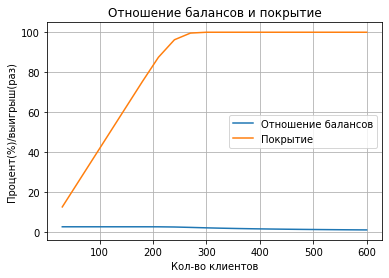

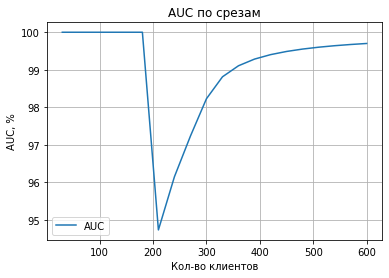

start_bucket  end_bucket  turget_in_bucket  bucket_bal (%)  coverage (%)  \
0              0          30                30      100.000000     12.552301   
1              0          60                60      100.000000     25.104603   
2              0          90                90      100.000000     37.656904   
3              0         120               120      100.000000     50.209205   
4              0         150               150      100.000000     62.761506   
5              0         180               180      100.000000     75.313808   
6              0         210               209       99.523810     87.447699   
7              0         240               230       95.833333     96.234310   
8              0         270               238       88.148148     99.581590   
9              0         300               239       79.666667    100.000000   
10             0         330               239       72.424242    100.000000   
11             0         360               239       66.388889    100.000000   
12             0         390               239       61.282051    100.000000   
13             0         420               239       56.904762    100.000000   
14             0         450               239       53.111111    100.000000   
15             0         480               239       49.791667    100.000000   
16             0         510               239       46.862745    100.000000   
17             0         540               239       44.259259    100.000000   
18             0         570               239       41.929825    100.000000   
19             0         600               239       39.833333    100.000000   

    base_bal (%)  bucket_bal/base_bal         auc  
0      38.362761             2.606695  100.000000  
1      38.362761             2.606695  100.000000  
2      38.362761             2.606695  100.000000  
3      38.362761             2.606695  100.000000  
4      38.362761             2.606695  100.000000  
5      38.362761             2.606695  100.000000  
6      38.362761             2.594282   94.736842  
7      38.362761             2.498082   96.152174  
8      38.362761             2.297753   97.236082  
9      38.362761             2.076667   98.230331  
10     38.362761             1.887879   98.813739  
11     38.362761             1.730556   99.107853  
12     38.362761             1.597436   99.285101  
13     38.362761             1.483333   99.403592  
14     38.362761             1.384444   99.488390  
15     38.362761             1.297917   99.552076  
16     38.362761             1.221569   99.601661  
17     38.362761             1.153704   99.641363  
18     38.362761             1.092982   99.673868  
19     38.362761             1.038333   99.700970

In [56]:
# Метрика отношение балансов для трейна

tr_table_cover_1 = final_model.balance_cover_1(X_train, y_train, step=30, end=600)
tr_table_cover_1

Всего записей в выборке:  268
Всего таргетов в выборке:  103


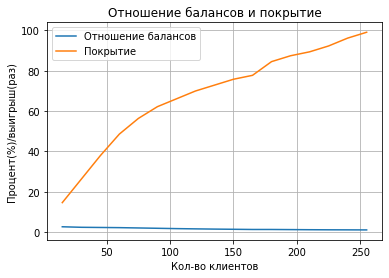

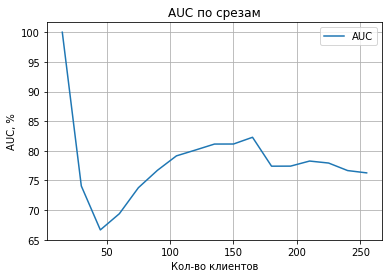

start_bucket  end_bucket  turget_in_bucket  bucket_bal (%)  coverage (%)  \
0              0          15                15      100.000000     14.563107   
1              0          30                27       90.000000     26.213592   
2              0          45                39       86.666667     37.864078   
3              0          60                50       83.333333     48.543689   
4              0          75                58       77.333333     56.310680   
5              0          90                64       71.111111     62.135922   
6              0         105                68       64.761905     66.019417   
7              0         120                72       60.000000     69.902913   
8              0         135                75       55.555556     72.815534   
9              0         150                78       52.000000     75.728155   
10             0         165                80       48.484848     77.669903   
11             0         180                87       48.333333     84.466019   
12             0         195                90       46.153846     87.378641   
13             0         210                92       43.809524     89.320388   
14             0         225                95       42.222222     92.233010   
15             0         240                99       41.250000     96.116505   
16             0         255               102       40.000000     99.029126   

    base_bal (%)  bucket_bal/base_bal         auc  
0      38.432836             2.601942  100.000000  
1      38.432836             2.341748   74.074074  
2      38.432836             2.255016   66.666667  
3      38.432836             2.168285   69.400000  
4      38.432836             2.012168   73.782961  
5      38.432836             1.850270   76.712740  
6      38.432836             1.685067   79.153418  
7      38.432836             1.561165   80.135995  
8      38.432836             1.445523   81.144444  
9      38.432836             1.353010   81.152066  
10     38.432836             1.261548   82.286765  
11     38.432836             1.257605   77.413175  
12     38.432836             1.200896   77.423280  
13     38.432836             1.139898   78.279293  
14     38.432836             1.098598   77.943320  
15     38.432836             1.073301   76.674547  
16     38.432836             1.040777   76.284762

In [57]:
# Метрика отношение балансов для валидации

te_table_cover_1 = final_model.balance_cover_1(X_valid, y_valid, step=15, end=250)
te_table_cover_1

#### Процентность таргета в бакетах

Всего записей в выборке:  623
Всего таргетов в выборке:  239


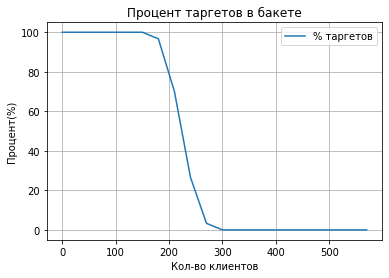

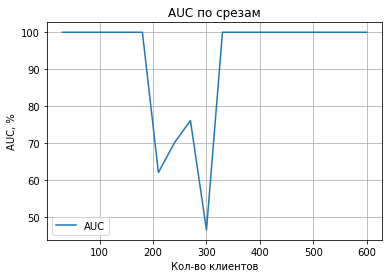

start_bucket  end_bucket  target_in_bucket  bucket_bal (%)  coverage (%)  \
0              0          30                30      100.000000     12.552301   
1             30          60                30      100.000000     12.552301   
2             60          90                30      100.000000     12.552301   
3             90         120                30      100.000000     12.552301   
4            120         150                30      100.000000     12.552301   
5            150         180                30      100.000000     12.552301   
6            180         210                29       96.666667     12.133891   
7            210         240                21       70.000000      8.786611   
8            240         270                 8       26.666667      3.347280   
9            270         300                 1        3.333333      0.418410   
10           300         330                 0        0.000000      0.000000   
11           330         360                 0        0.000000      0.000000   
12           360         390                 0        0.000000      0.000000   
13           390         420                 0        0.000000      0.000000   
14           420         450                 0        0.000000      0.000000   
15           450         480                 0        0.000000      0.000000   
16           480         510                 0        0.000000      0.000000   
17           510         540                 0        0.000000      0.000000   
18           540         570                 0        0.000000      0.000000   
19           570         600                 0        0.000000      0.000000   

    base_bal (%)  bucket_bal/base_bal         auc  
0      38.362761             2.606695  100.000000  
1      38.362761             2.606695  100.000000  
2      38.362761             2.606695  100.000000  
3      38.362761             2.606695  100.000000  
4      38.362761             2.606695  100.000000  
5      38.362761             2.606695  100.000000  
6      38.362761             2.519805   62.068966  
7      38.362761             1.824686   70.105820  
8      38.362761             0.695119   76.136364  
9      38.362761             0.086890   46.551724  
10     38.362761             0.000000  100.000000  
11     38.362761             0.000000  100.000000  
12     38.362761             0.000000  100.000000  
13     38.362761             0.000000  100.000000  
14     38.362761             0.000000  100.000000  
15     38.362761             0.000000  100.000000  
16     38.362761             0.000000  100.000000  
17     38.362761             0.000000  100.000000  
18     38.362761             0.000000  100.000000  
19     38.362761             0.000000  100.000000

In [58]:
# Метрика процента таргета для трейна

tr_table_cover_2 = final_model.balance_cover_2(X_train, y_train, step=30, end=600)
tr_table_cover_2

Всего записей в выборке:  268
Всего таргетов в выборке:  103


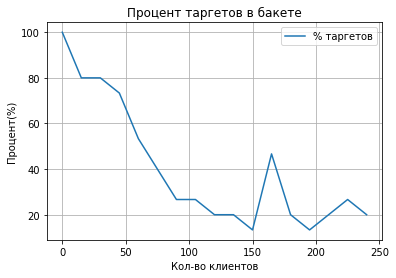

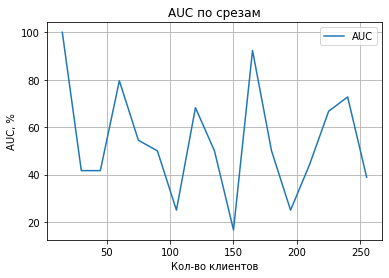

start_bucket  end_bucket  target_in_bucket  bucket_bal (%)  coverage (%)  \
0              0          15                15      100.000000     14.563107   
1             15          30                12       80.000000     11.650485   
2             30          45                12       80.000000     11.650485   
3             45          60                11       73.333333     10.679612   
4             60          75                 8       53.333333      7.766990   
5             75          90                 6       40.000000      5.825243   
6             90         105                 4       26.666667      3.883495   
7            105         120                 4       26.666667      3.883495   
8            120         135                 3       20.000000      2.912621   
9            135         150                 3       20.000000      2.912621   
10           150         165                 2       13.333333      1.941748   
11           165         180                 7       46.666667      6.796117   
12           180         195                 3       20.000000      2.912621   
13           195         210                 2       13.333333      1.941748   
14           210         225                 3       20.000000      2.912621   
15           225         240                 4       26.666667      3.883495   
16           240         255                 3       20.000000      2.912621   

    base_bal (%)  bucket_bal/base_bal         auc  
0      38.432836             2.601942  100.000000  
1      38.432836             2.081553   41.666667  
2      38.432836             2.081553   41.666667  
3      38.432836             1.908091   79.545455  
4      38.432836             1.387702   54.464286  
5      38.432836             1.040777   50.000000  
6      38.432836             0.693851   25.000000  
7      38.432836             0.693851   68.181818  
8      38.432836             0.520388   50.000000  
9      38.432836             0.520388   16.666667  
10     38.432836             0.346926   92.307692  
11     38.432836             1.214239   50.000000  
12     38.432836             0.520388   25.000000  
13     38.432836             0.346926   44.230769  
14     38.432836             0.520388   66.666667  
15     38.432836             0.693851   72.727273  
16     38.432836             0.520388   38.888889

In [59]:
# Метрика процента таргета для валидации

te_table_cover_2 = final_model.balance_cover_2(X_valid, y_valid, step=15, end=250)
te_table_cover_2

## Этап калибровки

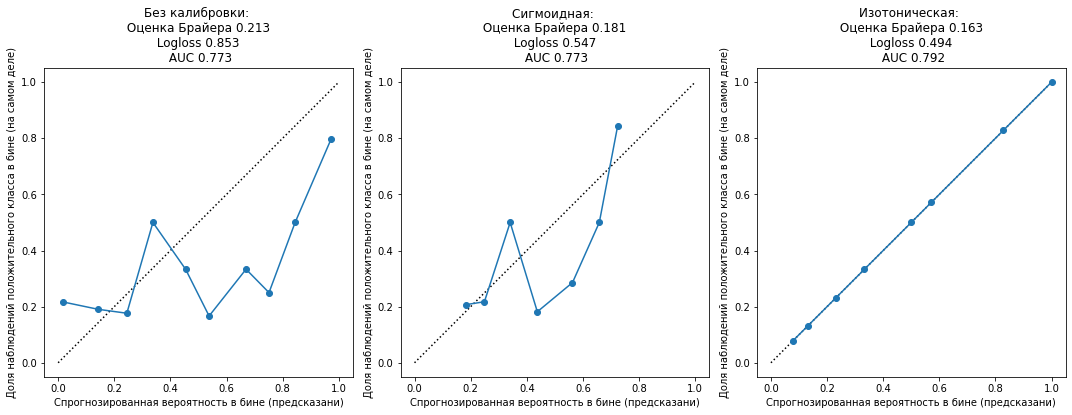

In [60]:
# Калибровка на валидации

final_model.calibration(X_valid, y_valid, n_bins=10)

### Формирование базового скора, сигмоидной калибровки и изотонической

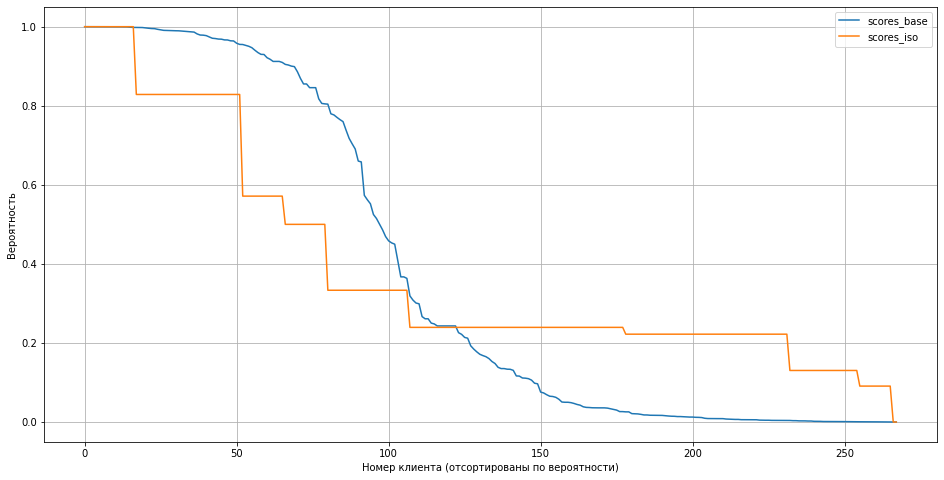

scores_base  scores_sigm  scores_iso  target
0       0.999999     0.731193    1.000000       1
1       0.999998     0.731192    1.000000       1
2       0.999995     0.731191    1.000000       1
3       0.999991     0.731189    1.000000       1
4       0.999987     0.731187    1.000000       1
..           ...          ...         ...     ...
263     0.000245     0.178931    0.090909       0
264     0.000170     0.178903    0.090909       0
265     0.000112     0.178881    0.090909       1
266     0.000077     0.178868    0.000000       0
267     0.000027     0.178850    0.000000       0

[268 rows x 4 columns]

In [61]:
# Выбор калибровки и сравнение с базовым скором

scores = final_model.calibration_compare(X_valid, y_valid, calib_compare='scores_iso')
scores

## Сохранение пиклов

In [62]:
final_model.get_pickles(
                columns=True,
                prep_pipe=True,
                model=True,
                calibration=True,
                type_calibration='iso',
                path='final_results')

Директория существует


'Все атрибуты сохранены!'

## Интерпретация модели

In [63]:
# Shap интерпретация

# задаем класс
c_shap = PlotShap(model=final_model.model, sample=final_model.prep_pipe.transform(X_train))
# обучаем
c_shap.fit_shap()

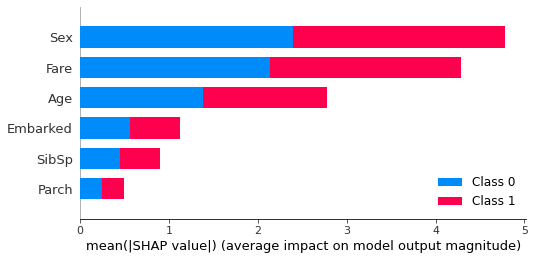

In [64]:
c_shap.create_plot_shap(plot_type='bar', number_features=30)

In [65]:
c_shap.create_shap_report(path_base='./shap_report')

Директория существует


In [66]:
# PDP-ICE интерпретация

# Задаем необходимые факторы для анализа, в нужном нам порядке
feats = features[:5]

# Задаем класс PlotPDP(model - 'наша модель', 
##                   X - 'датасет на котором обучалась модель',
##                   main_features - 'список факторов необходимых для анализа')

pdp_plot = PlotPDP(model=final_model.model, X=final_model.prep_pipe.transform(X_train),main_features=feats)

Sex


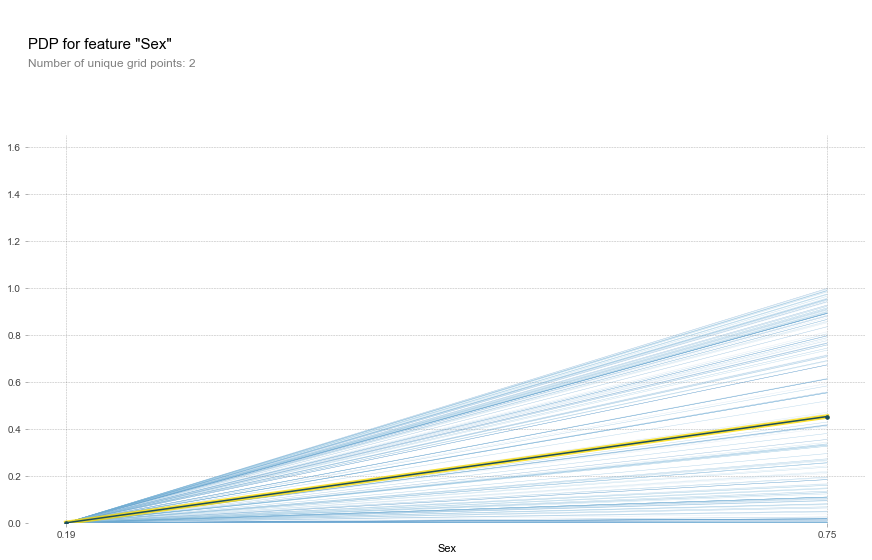

Fare


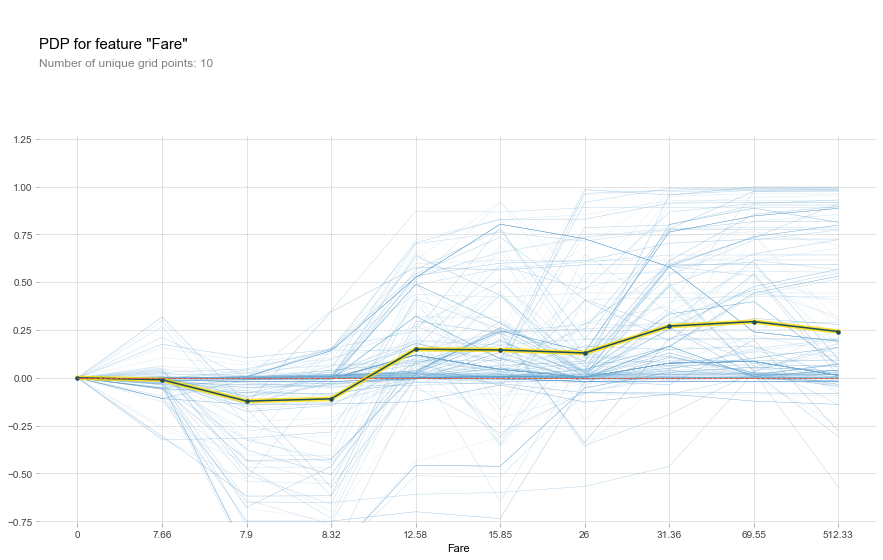

Age


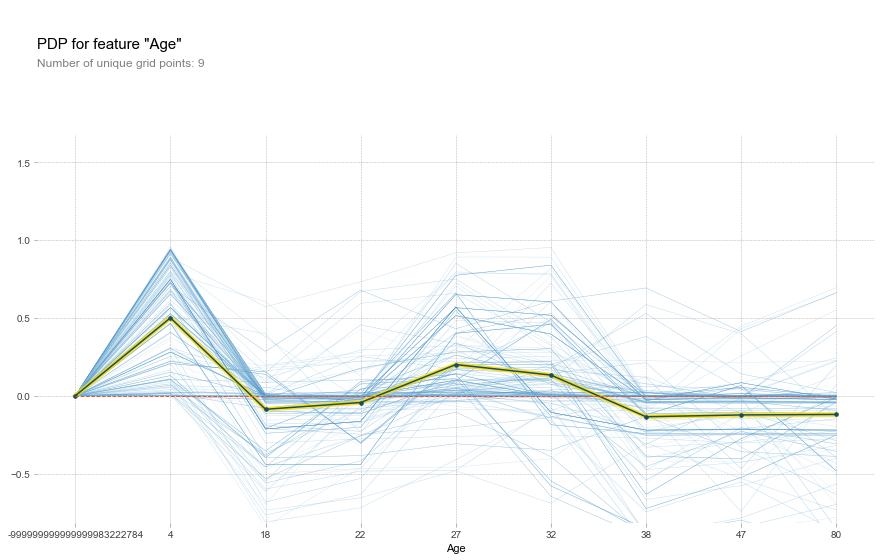

SibSp


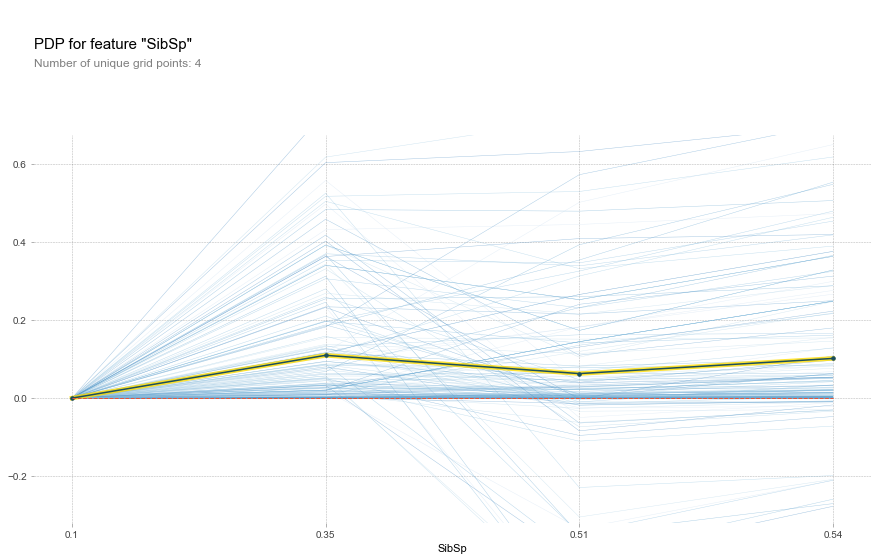

Embarked


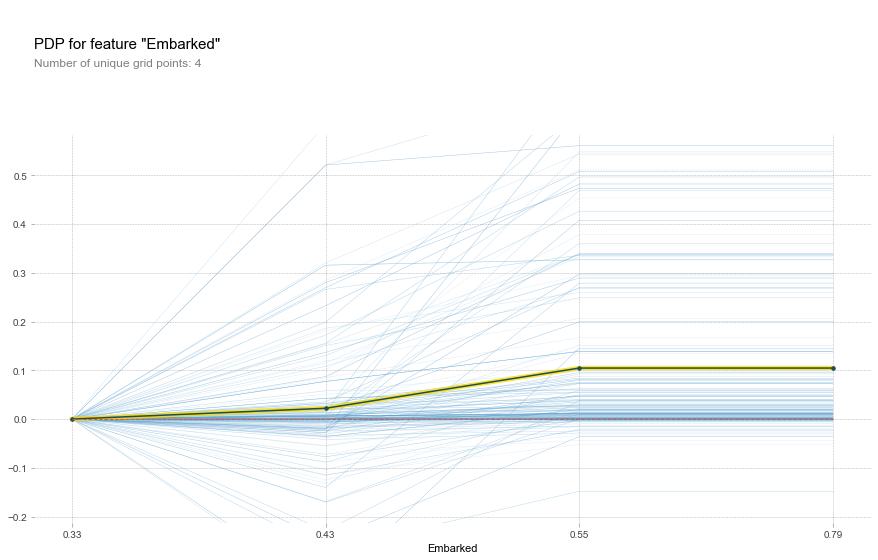

In [67]:
# Выводим графики по каждому фактору функцией create_feature_plot(save = True/False - 'Сохранить/не сохранять графики',
##                                                           frac_to_plot = 0.1 - 'доля сэмпла для анализа, по умолчанию 10%',
##                                                           n_jobs = -1,
##                                                           path = './pdp_ice_plots' - 'директория куда будут сохранены графики')

pdp_plot.create_feature_plot(save=True, frac_to_plot=0.3)

Интерпретация: Как факторы  ['Fare', 'Age'] совместо влияют на предсказание. Чем ярчке (желтая) ячейка, тем сильнее влияние в совокупности: Для классификации - растет вероятность отнесения к целевой метке класса; Для регрессии - растет значение предсказания. Чем темнее (фиолетовая) ячейка - обратная ситуация.


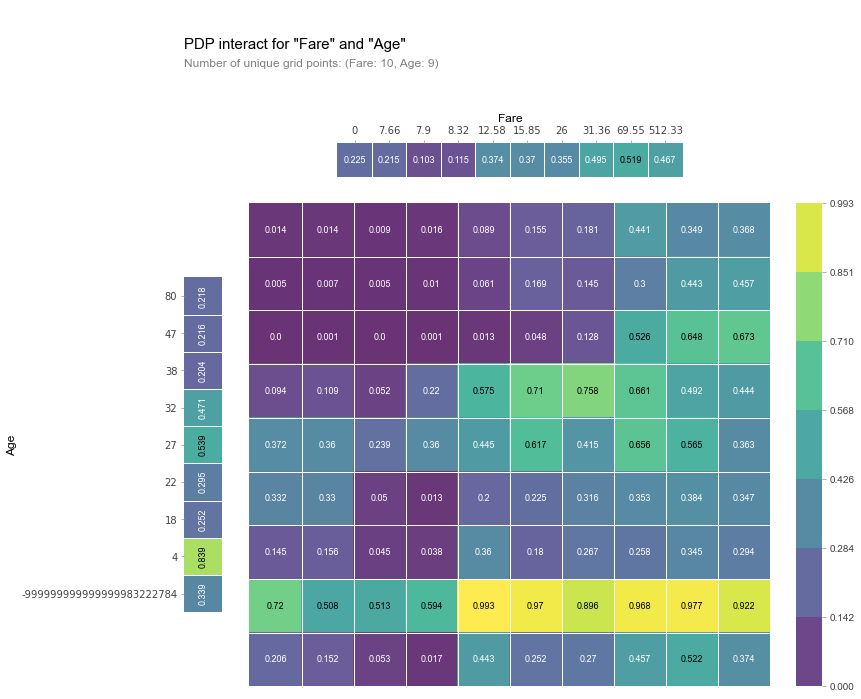

In [68]:
pdp_plot.create_interact_plot(features=['Fare','Age'], save=True)

In [69]:
# Генерация html отчета PDP-ICE plots функцией create_pdp_report(path_base = './pdp_ice_plots' - 'необходимая директория для графиков/отчета')

pdp_plot.create_pdp_report()

Загрузка всех сохраненных изображений 

Загрузка завершена. 

Отчет сгенерирован.
